Os objetivos deste notebook são usar o modelo treinado para:
- gerar as métricas de validação
- gerar gráficos para com predições

In [1]:
import sys
sys.path.append("..")

# Environment configuration
import raw_data_manager.raw_data_acquisition as rda
import raw_data_manager.raw_data_inspector as rdi
import raw_data_manager.raw_data_splitter as rds
from data_exploration.metric_acquisition import MetricAcquisition
from raw_data_manager.models import EventClassType
from data_preparation.transformation_manager import TransformationManager
from constants import storage_config
from data_exploration import visualization_helper as visual
import pathlib
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt

import seaborn as sns
from tensorflow import keras, math


# Set default logging level.
from absl import logging
logging.set_verbosity(logging.DEBUG)
import pickle

/home/ubuntu/lemi_3w/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-25 18:56:00.109433: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-25 18:56:00.114733: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-25 18:56:00.172962: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-25 18:56:00.173015: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unabl

In [2]:
# Get transformed files paths
TRANSFORMATION_NAME_PREFIX = "transform-isdt-"
train_tranformed_folder_name = "dataset_converted_v10101_split-20_source-all_class-all_well-all_train"
test_tranformed_folder_name = "dataset_converted_v10101_split-20_source-all_class-all_well-all_test"
validation_tranformed_folder_name = "dataset_converted_v10101_split-20_source-all_class-all_well-all_validation"

train_tranformed_dataset_dir = storage_config.DIR_PROJECT_DATA / (TRANSFORMATION_NAME_PREFIX + train_tranformed_folder_name)
validation_tranformed_dataset_dir = storage_config.DIR_PROJECT_DATA / (TRANSFORMATION_NAME_PREFIX + validation_tranformed_folder_name)
test_tranformed_dataset_dir = storage_config.DIR_PROJECT_DATA / (TRANSFORMATION_NAME_PREFIX + test_tranformed_folder_name)

# Generate inspectors for the transformed data
train_inspector_converted = rdi.RawDataInspector(
    train_tranformed_dataset_dir,
    storage_config.DIR_PROJECT_CACHE / "all_wells_transformed-train.parquet",
    use_cached=False
)
validation_inspector_transformed = rdi.RawDataInspector(
    validation_tranformed_dataset_dir,
    storage_config.DIR_PROJECT_CACHE / "all_wells_transformed-validation.parquet",
    use_cached=False
)
test_inspector_transformed = rdi.RawDataInspector(
    test_tranformed_dataset_dir,
    storage_config.DIR_PROJECT_CACHE / "all_wells_transformed-test.parquet",
    use_cached=False
)

# Get list of paths for the events in each of the data groups (train, val, test)
train_metadata_converted = train_inspector_converted.get_metadata_table()
train_transformed_file_path_list = train_metadata_converted["path"].to_list()

validation_metadata_transformed = validation_inspector_transformed.get_metadata_table()
validation_transformed_file_path_list = validation_metadata_transformed["path"].to_list()

test_metadata_transformed = test_inspector_transformed.get_metadata_table()
test_transformed_file_path_list = test_metadata_transformed["path"].to_list()

# shuffle
random.shuffle(train_transformed_file_path_list)
random.shuffle(validation_transformed_file_path_list)
random.shuffle(test_transformed_file_path_list)

INFO:absl:Processing 416 events of class type 0.
DONE: 100%|██████████| 416/416 [00:00<00:00, 3590.64it/s]INFO:absl:Processing 241 events of class type 4.

DONE: 100%|██████████| 241/241 [00:00<00:00, 1793.99it/s]INFO:absl:Processing 312 events of class type 5.

DONE: 100%|██████████| 9/9 [00:00<00:00, 102.02it/s]
INFO:absl:Processing 154 events of class type 6.
DONE: 100%|██████████| 154/154 [00:00<00:00, 1238.26it/s]INFO:absl:Processing 57 events of class type 8.

DONE: 100%|██████████| 57/57 [00:00<00:00, 510.50it/s]INFO:absl:Processing 23 events of class type 2.

DONE: 100%|██████████| 74/74 [00:00<00:00, 589.89it/s]
INFO:absl:Processing 59 events of class type 0.
DONE: 100%|██████████| 59/59 [00:00<00:00, 676.16it/s]INFO:absl:Processing 34 events of class type 4.

DONE: 100%|██████████| 34/34 [00:00<00:00, 305.27it/s]INFO:absl:Processing 45 events of class type 5.

DONE: 100%|██████████| 45/45 [00:00<00:00, 367.22it/s]
INFO:absl:Processing 13 events of class type 1.
DONE: 100%|███

In [3]:
train_data_gen = TransformationManager.data_generator_loop(train_transformed_file_path_list)
validation_data_gen = TransformationManager.data_generator_loop(validation_transformed_file_path_list)
test_data_gen = TransformationManager.data_generator_loop(test_transformed_file_path_list)

In [4]:
best_model_path = "melhor_modelo_ever_all_data.pkl"
with open(best_model_path, 'rb') as file:
    # Load the data from the file
    best_model = pickle.load(file)

In [5]:
best_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20, 50)            11400     
                                                                 
 lstm_4 (LSTM)               (None, 85)                46240     
                                                                 
 dropout_1 (Dropout)         (None, 85)                0         
                                                                 
 dense_4 (Dense)             (None, 130)               11180     
                                                                 
 dense_5 (Dense)             (None, 9)                 1179      
                                                                 
Total params: 69999 (273.43 KB)
Trainable params: 69999 (273.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
test_data_gen = TransformationManager.data_generator_non_loop(test_transformed_file_path_list)
num_steps = len(test_transformed_file_path_list)

best_model.evaluate(
    test_data_gen,
    steps=num_steps,
    verbose=1,
)

395/395 [==============================] - 16s 38ms/step - loss: 1.4804 - accuracy: 0.9328


[1.4804333448410034, 0.9328254461288452]

In [85]:
# Predicitions
test_data_gen = TransformationManager.data_generator_non_loop(test_transformed_file_path_list)

y_test_predictions = best_model.predict(
    test_data_gen,
)

(
    f"Number of predictions: {len(y_test_predictions)}", 
    f"Shape of y array: {y_test_predictions.shape}", 
    y_test_predictions[0]
)

395/395 [==============================] - 14s 35ms/step


('Number of predictions: 162636',
 'Shape of y array: (162636, 9)',
 array([2.84e-01, 6.75e-01, 7.46e-04, 2.92e-03, 1.82e-03, 2.77e-03,
        5.29e-04, 3.23e-02, 2.15e-05], dtype=float32))

In [20]:
# True labels
test_data_gen = TransformationManager.data_generator_non_loop(test_transformed_file_path_list)
y_test_labels = []

for X, y in test_data_gen:
    y_test_labels.append(y)

y_test_labels = np.concatenate(y_test_labels, axis=0)

(
    f"Number of labels: {len(y_test_labels)}", 
    f"Shape of y array: {y_test_labels.shape}", 
    y_test_labels[0],
)

('Number of labels: 162636',
 'Shape of y array: (162636, 9)',
 array([1, 0, 0, 0, 0, 0, 0, 0, 0]))

In [30]:
res = np.argwhere(y_test_labels == [1, 0, 0, 0, 0, 0, 0, 0, 0])
print(len(res[0]))
res

2


array([[     0,      0],
       [     0,      1],
       [     0,      2],
       ...,
       [162635,      6],
       [162635,      7],
       [162635,      8]])

### Matrix de confusão

In [86]:
y_test_labels_1d = np.argmax(y_test_labels, axis=1)
y_test_predictions_1d = np.argmax(y_test_predictions, axis=1)

num_outputs = len(EventClassType)

consusion_array = math.confusion_matrix(
    y_test_labels_1d,
    y_test_predictions_1d,
    num_classes=num_outputs,
)
consusion_array

<tf.Tensor: shape=(9, 9), dtype=int32, numpy=
array([[31428,  2392,    78,     0,   603,   266,   342,   576,   255],
       [ 1006, 28822,    96,   206,     0,     0,     0,   452,     0],
       [   35,     0,  1395,     0,     3,    12,     0,     0,    29],
       [  179,     0,     0, 12989,   327,  1419,     0,     0,   257],
       [  969,     0,     0,     1,  5984,     3,     0,     0,     0],
       [    0,    17,     0,    13,     6, 41895,     0,     0,     0],
       [   20,     0,     0,     0,     0,     0, 18051,     0,     0],
       [    0,   606,     0,     0,     0,     0,     0,  5184,     0],
       [    0,     0,     0,     0,     0,   757,     0,     0,  5963]],
      dtype=int32)>

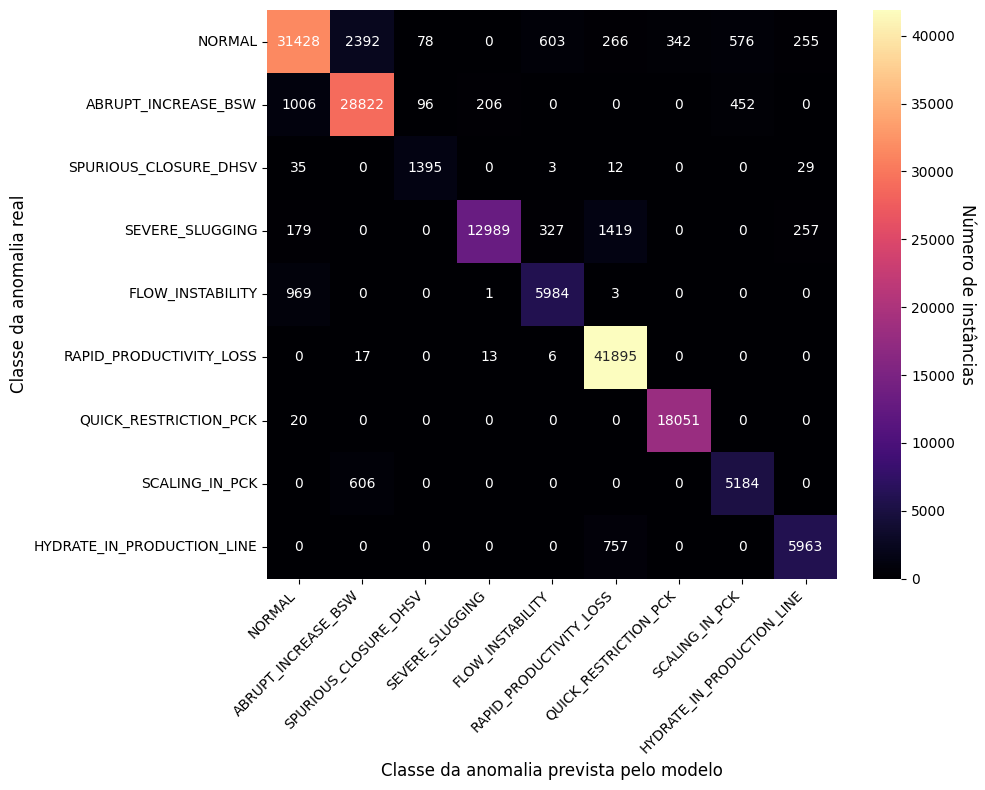

In [105]:
event_class_names = [x.name for x in EventClassType]

plt.figure(figsize=(10, 8))

# Create a heatmap
heatmap = sns.heatmap(consusion_array,
                      annot=True,
                      cmap='magma',
                      fmt="d",
                      xticklabels=event_class_names,
                      yticklabels=event_class_names,
                      annot_kws={"size": 10})  # Adjust annotation font size

# Add labels and title
plt.xlabel('Classe da anomalia prevista pelo modelo', fontsize=12)  # Adjust label font size
plt.ylabel('Classe da anomalia real', fontsize=12)  # Adjust label font size
plt.xticks(rotation=45, ha="right")

# Add a color bar for reference
cbar = heatmap.collections[0].colorbar
cbar.set_label('Número de instâncias', rotation=270, labelpad=15, fontsize=12)  # Adjust color bar font size

plt.tight_layout()
plt.show()

### Métricas de validação

In [93]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support as score
pd.set_option('display.precision', 2)

res = []
for l in range(len(EventClassType)):
    prec,recall,_,_ = score(np.array(y_test_labels_1d)==l,
                                                      np.array(y_test_predictions_1d)==l,
                                                      pos_label=True,average=None)
    res.append([l,recall[0],recall[1]])

res = pd.DataFrame(res,columns = ['class','sensitivity','specificity'])
res

class  sensitivity  specificity
0      0         0.98         0.87
1      1         0.98         0.94
2      2         1.00         0.95
3      3         1.00         0.86
4      4         0.99         0.86
5      5         0.98         1.00
6      6         1.00         1.00
7      7         0.99         0.90
8      8         1.00         0.89

[0.9825645639957062,
 0.9771684310963696,
 0.9989203410233182,
 0.9985081205709829,
 0.9939683579673559,
 0.9796445880452342,
 0.9976342821568153,
 0.9934458003391862,
 0.9965301829190076]

'[0.9825645639957062, 0.9771684310963696, 0.9989203410233182, 0.9985081205709829, 0.9939683579673559, 0.9796445880452342, 0.9976342821568153, 0.9934458003391862, 0.9965301829190076]'

In [104]:
precision, recall, f1, _ = score(y_test_labels_1d, y_test_predictions_1d)

sensitivity = [round(number, 2) for number in res["sensitivity"].to_list()]


print("precision: {}\n\n".format(precision))
print("recall: {}\n\n".format(recall))
print(f"sensitivity: {sensitivity}\n\n")
print("fscore: {}\n\n".format(f1))


precision: [0.93 0.91 0.89 0.98 0.86 0.94 0.98 0.83 0.92]


recall: [0.87 0.94 0.95 0.86 0.86 1.   1.   0.9  0.89]


sensitivity: [0.98, 0.98, 1.0, 1.0, 0.99, 0.98, 1.0, 0.99, 1.0]


fscore: [0.9  0.92 0.92 0.92 0.86 0.97 0.99 0.86 0.9 ]




### Análise da performance para cada classe de anomalia

In [49]:
np.set_printoptions(precision=2)

list_predictions_during_amomaly = []
list_predictions_during_normal = []

for event_class_type in EventClassType:
    event_class_type_name = event_class_type.name
    event_class_type_value = event_class_type.value
    event_path_list = test_metadata_transformed[test_metadata_transformed["class_type"] == event_class_type_name]["path"].to_list()
    
    y_predictions = best_model.predict(
        TransformationManager.data_generator_non_loop(event_path_list),
    )
    y_labels = []
    for X, y in TransformationManager.data_generator_non_loop(event_path_list):
        y_labels.append(y)
    y_labels = np.concatenate(y_labels, axis=0)

    print(f"Average results regarding anomaly type: {event_class_type_name}")
    # Verificar performance região de anomalia
    row_to_compare = np.zeros(9)
    row_to_compare[event_class_type_value] = 1
    anomaly_indexes = np.where(np.all(y_labels == row_to_compare, axis=1))[0]

    anomaly_prediction = y_predictions[anomaly_indexes]
    list_predictions_during_amomaly.append(np.mean(anomaly_prediction, axis=0))
    print(f"Mean predictions during anomaly:", np.mean(anomaly_prediction, axis=0))


    # Verificar performance região normal
    if event_class_type_value == 0:
        continue

    row_to_compare = np.zeros(9)
    row_to_compare[0] = 1
    normal_indexes = np.where(np.all(y_labels == row_to_compare, axis=1))[0]
    normal_prediction = y_predictions[normal_indexes]
    list_predictions_during_normal.append(np.mean(normal_prediction, axis=0))
    print(f"Mean predictions during normal:", np.mean(normal_prediction, axis=0))

    print("\n\n\n")
    

      3/Unknown - 0s 29ms/step

119/119 [==============================] - 3s 27ms/step
Average results regarding anomaly type: NORMAL
Mean predictions during anomaly: [9.67e-01 1.60e-04 5.03e-05 1.22e-03 3.09e-02 2.16e-04 2.01e-04 7.21e-04
 4.27e-06]
26/26 [==============================] - 2s 77ms/step
Average results regarding anomaly type: ABRUPT_INCREASE_BSW
Mean predictions during anomaly: [1.77e-01 7.58e-01 4.21e-03 1.26e-02 1.60e-03 1.54e-03 2.92e-04 4.50e-02
 3.31e-05]
Mean predictions during normal: [4.69e-01 4.71e-01 1.85e-03 4.96e-03 2.58e-03 2.00e-03 5.18e-04 4.78e-02
 4.56e-05]




7/7 [==============================] - 0s 26ms/step
Average results regarding anomaly type: SPURIOUS_CLOSURE_DHSV
Mean predictions during anomaly: [6.91e-02 3.67e-04 9.00e-01 1.33e-03 4.03e-03 7.79e-03 3.12e-04 2.97e-04
 1.66e-02]
Mean predictions during normal: [1.82e-01 1.66e-05 2.50e-01 5.85e-06 2.78e-04 7.03e-04 2.34e-05 7.49e-05
 5.66e-01]




22/22 [==============================] - 1s 52ms/step
Average results regardin

/home/ubuntu/lemi_3w/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/lemi_3w/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


69/69 [==============================] - 1s 13ms/step
Average results regarding anomaly type: FLOW_INSTABILITY
Mean predictions during anomaly: [1.49e-01 4.76e-04 9.19e-05 5.04e-03 8.44e-01 4.23e-04 4.56e-05 1.11e-03
 2.65e-05]
Mean predictions during normal: [nan nan nan nan nan nan nan nan nan]




90/90 [==============================] - 4s 42ms/step
Average results regarding anomaly type: RAPID_PRODUCTIVITY_LOSS
Mean predictions during anomaly: [2.98e-03 3.31e-04 3.30e-04 7.45e-04 4.37e-04 9.94e-01 1.23e-05 6.91e-05
 7.42e-04]
Mean predictions during normal: [0.22 0.33 0.01 0.01 0.01 0.38 0.   0.03 0.01]




44/44 [==============================] - 2s 39ms/step
Average results regarding anomaly type: QUICK_RESTRICTION_PCK
Mean predictions during anomaly: [4.76e-02 9.27e-07 1.90e-04 1.83e-06 5.82e-05 1.24e-05 9.52e-01 3.87e-06
 1.05e-04]
Mean predictions during normal: [3.25e-01 3.04e-05 1.38e-03 6.82e-05 1.52e-03 2.06e-04 6.70e-01 1.87e-04
 1.69e-03]




2/2 [======================

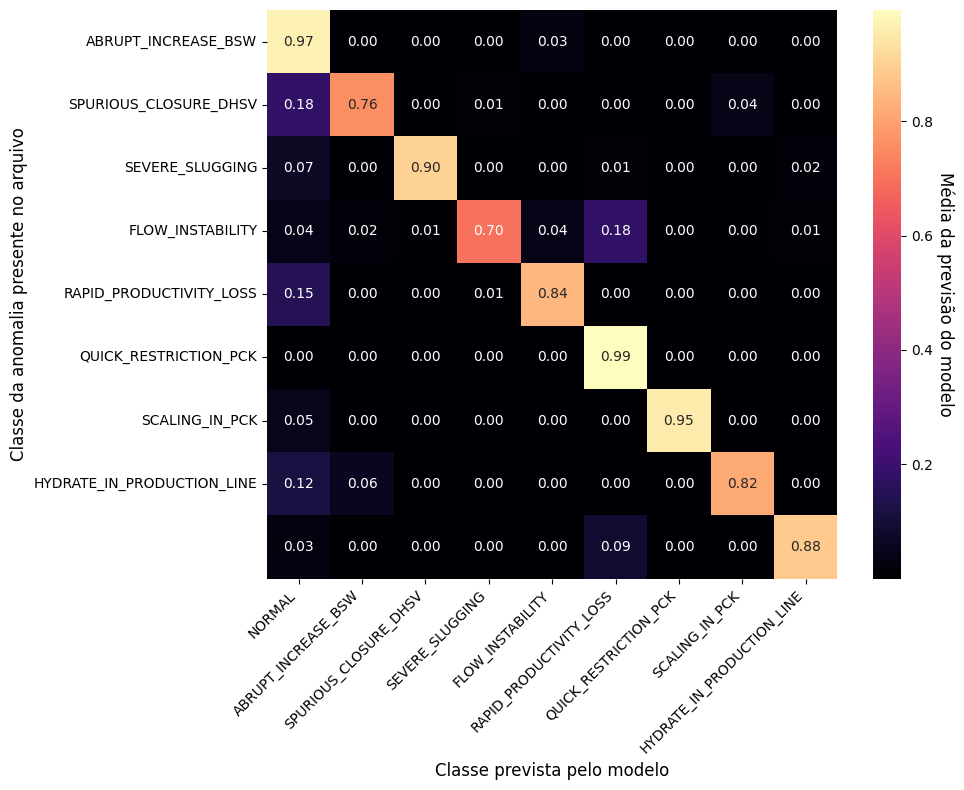

In [81]:
event_class_names = [x.name for x in EventClassType]

plt.figure(figsize=(10, 8))

# Create a heatmap
heatmap = sns.heatmap(list_predictions_during_amomaly,
                      annot=True,
                      cmap='magma',
                      fmt=".2f",
                      xticklabels=event_class_names,
                      yticklabels=event_class_names[1:],
                      annot_kws={"size": 10})  # Adjust annotation font size

# Add labels and title
plt.xlabel('Classe prevista pelo modelo', fontsize=12)  # Adjust label font size
plt.ylabel('Classe da anomalia presente no arquivo', fontsize=12)  # Adjust label font size
plt.xticks(rotation=45, ha="right")

# Add a color bar for reference
cbar = heatmap.collections[0].colorbar
cbar.set_label('Média da previsão do modelo', rotation=270, labelpad=15, fontsize=12)  # Adjust color bar font size

plt.tight_layout()
plt.show()

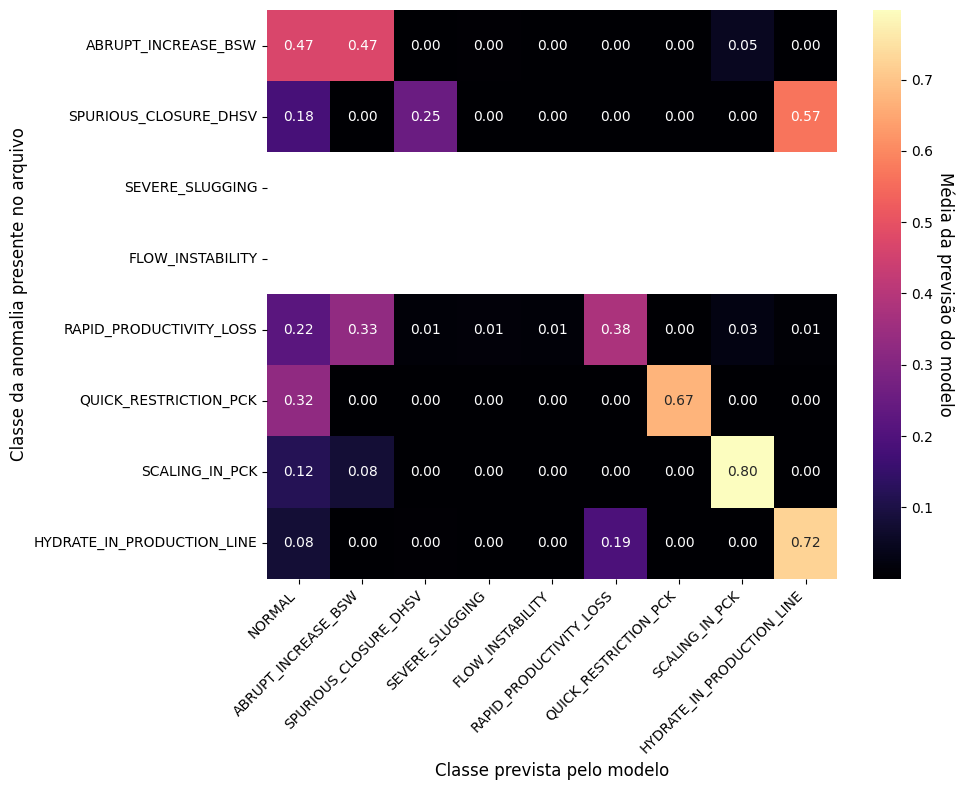

In [80]:
# Create a figure with a larger size
plt.figure(figsize=(10, 8))

# Create a heatmap
heatmap = sns.heatmap(list_predictions_during_normal,
                      annot=True,
                      cmap='magma',
                      fmt=".2f",
                      xticklabels=event_class_names,
                      yticklabels=event_class_names[1:],
                      annot_kws={"size": 10})  # Adjust annotation font size

# Add labels and title
plt.xlabel('Classe prevista pelo modelo', fontsize=12)  # Adjust label font size
plt.ylabel('Classe da anomalia presente no arquivo', fontsize=12)  # Adjust label font size
plt.xticks(rotation=45, ha="right")

# Add a color bar for reference
cbar = heatmap.collections[0].colorbar
cbar.set_label('Média da previsão do modelo', rotation=270, labelpad=15, fontsize=12)  # Adjust color bar font size

plt.tight_layout()
plt.show()

In [7]:
EventClassType
test_metadata_transformed

class_type     source  well_id  \
hash_id                                        
8617ce9           NORMAL       REAL      2.0   
6a65bd1           NORMAL       REAL      2.0   
9258d5b           NORMAL       REAL      2.0   
5032568           NORMAL       REAL      6.0   
b3f653c           NORMAL       REAL      4.0   
...                  ...        ...      ...   
4122b0e  SEVERE_SLUGGING  SIMULATED      NaN   
b2eebb5  SEVERE_SLUGGING  SIMULATED      NaN   
e12254f  SEVERE_SLUGGING  SIMULATED      NaN   
092ed4e  SEVERE_SLUGGING  SIMULATED      NaN   
5e17d0a  SEVERE_SLUGGING       REAL     14.0   

                                                      path  \
hash_id                                                      
8617ce9  /home/ubuntu/lemi_3w/data/transform-isdt-datas...   
6a65bd1  /home/ubuntu/lemi_3w/data/transform-isdt-datas...   
9258d5b  /home/ubuntu/lemi_3w/data/transform-isdt-datas...   
5032568  /home/ubuntu/lemi_3w/data/transform-isdt-datas...   
b3f653c  /home/ubuntu/lemi_3w/data/transform-isdt-datas...   
...                                                    ...   
4122b0e  /home/ubuntu/lemi_3w/data/transform-isdt-datas...   
b2eebb5  /home/ubuntu/lemi_3w/data/transform-isdt-datas...   
e12254f  /home/ubuntu/lemi_3w/data/transform-isdt-datas...   
092ed4e  /home/ubuntu/lemi_3w/data/transform-isdt-datas...   
5e17d0a  /home/ubuntu/lemi_3w/data/transform-isdt-datas...   

                  timestamp  file_size num_timesteps  
hash_id                                               
8617ce9 2017-06-13 12:00:00     289450          None  
6a65bd1 2017-06-22 19:03:16     287386          None  
9258d5b 2017-06-22 14:01:27     289450          None  
5032568 2017-08-20 06:00:00     290482          None  
b3f653c 2014-08-07 02:01:07     103690          None  
...                     ...        ...           ...  
4122b0e                 NaT    1047970          None  
b2eebb5                 NaT     204826          None  
e12254f                 NaT    1047970          None  
092ed4e                 NaT     720826          None  
5e17d0a 2017-09-20 06:02:28     288418          None  

[395 rows x 7 columns]

In [ ]:
test_metadata_transformed = test_inspector_transformed.get_metadata_table()
test_transformed_file_path_list = test_metadata_transformed["path"].to_list()

### Visualização de eventos com suas predições

In [109]:
variable_names = [event_class_type.name for event_class_type in EventClassType]

def prepare_prediction_array(
    predictions: np.array, 
    window_size: int, 
    subsample_rate: int,
    length: int,
):
    num_prediction_classes = predictions.shape[1]
    predictions = np.insert(
        predictions, 0, np.zeros((window_size - 1, num_prediction_classes)), axis=0
    )
    predictions = np.repeat(predictions, subsample_rate, axis=0)
    return predictions[0:length, :]

In [107]:
def show_event_with_prediction(file_name, class_type: int):
    path_original = f"../data/dataset_converted_v10101_split-20_source-all_class-all_well-all_train/{class_type}/{file_name}.parquet"
    path_transformed = f"../data/transform-isdt-dataset_converted_v10101_split-20_source-all_class-all_well-all_train/{class_type}/{file_name}.npz"

    event = rda.get_event(path_original)
    X, _ = TransformationManager.retrieve_pair_array(pathlib.Path(path_transformed))

    predictions = best_model.predict(X)
    predictions_prepared = prepare_prediction_array(predictions.copy(), window_size=20, subsample_rate=60, length=event.shape[0])

    visual.display_entire_event(
        event.copy(),
        EventClassType(class_type).name,
        predictions_prepared.copy(),
        variable_names,
        True, 'linear', language='pt')

9/9 [==============================] - 0s 7ms/step


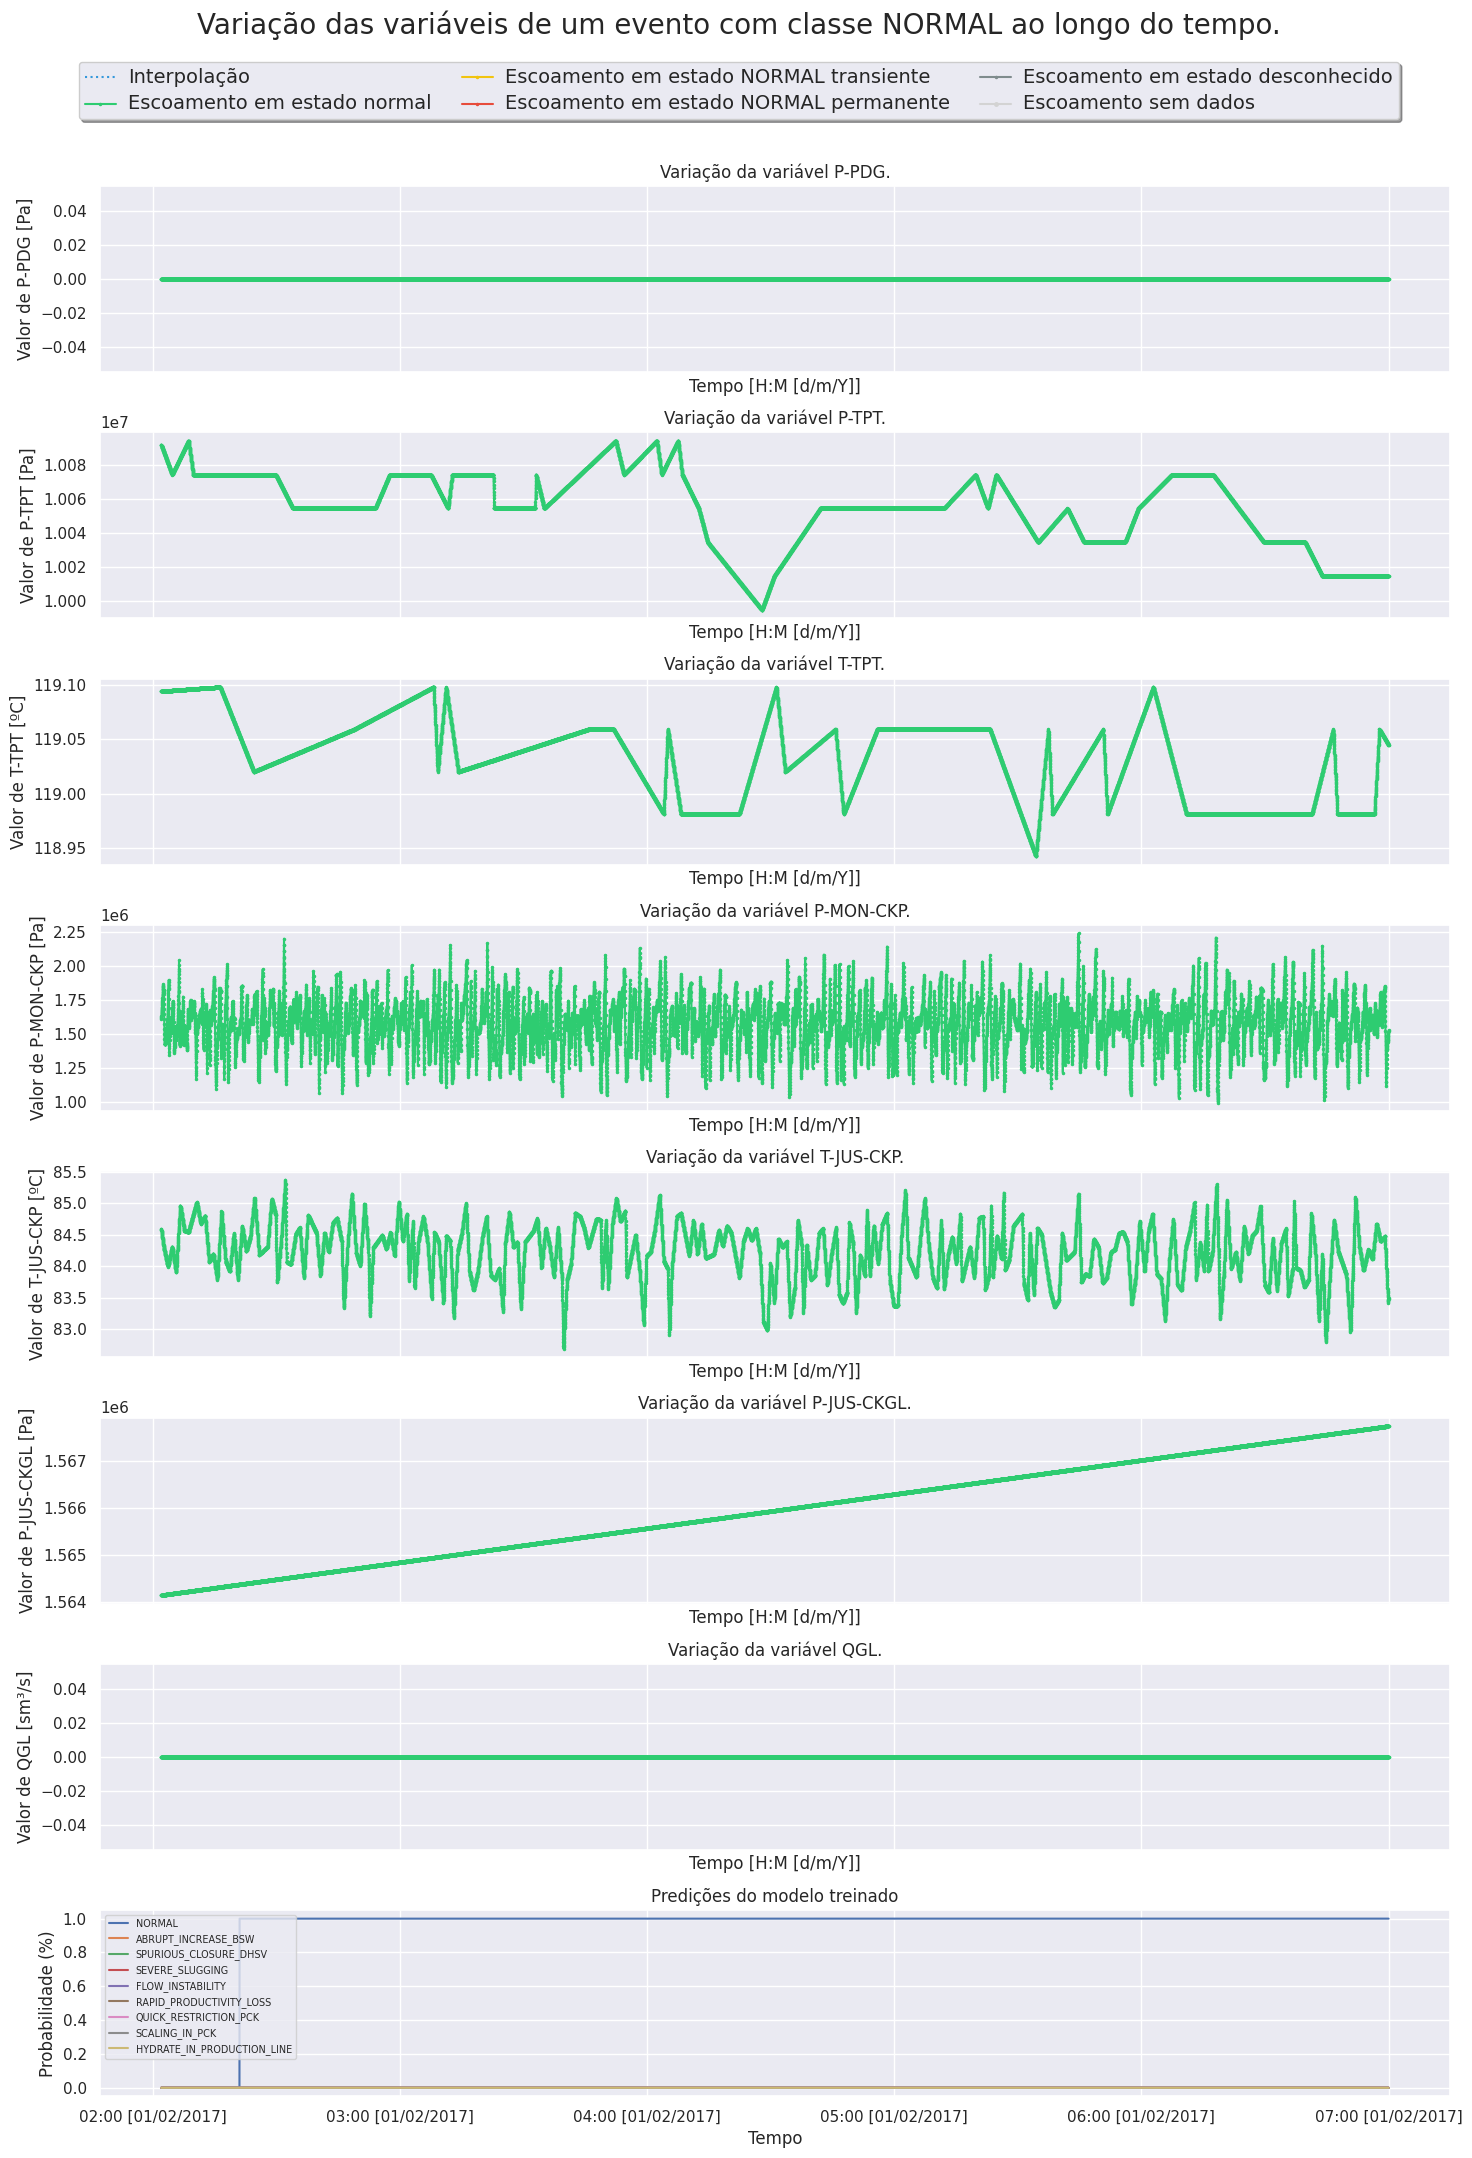

In [59]:
show_event_with_prediction("WELL-00001_20170201020207", 0)

46/46 [==============================] - 0s 8ms/step


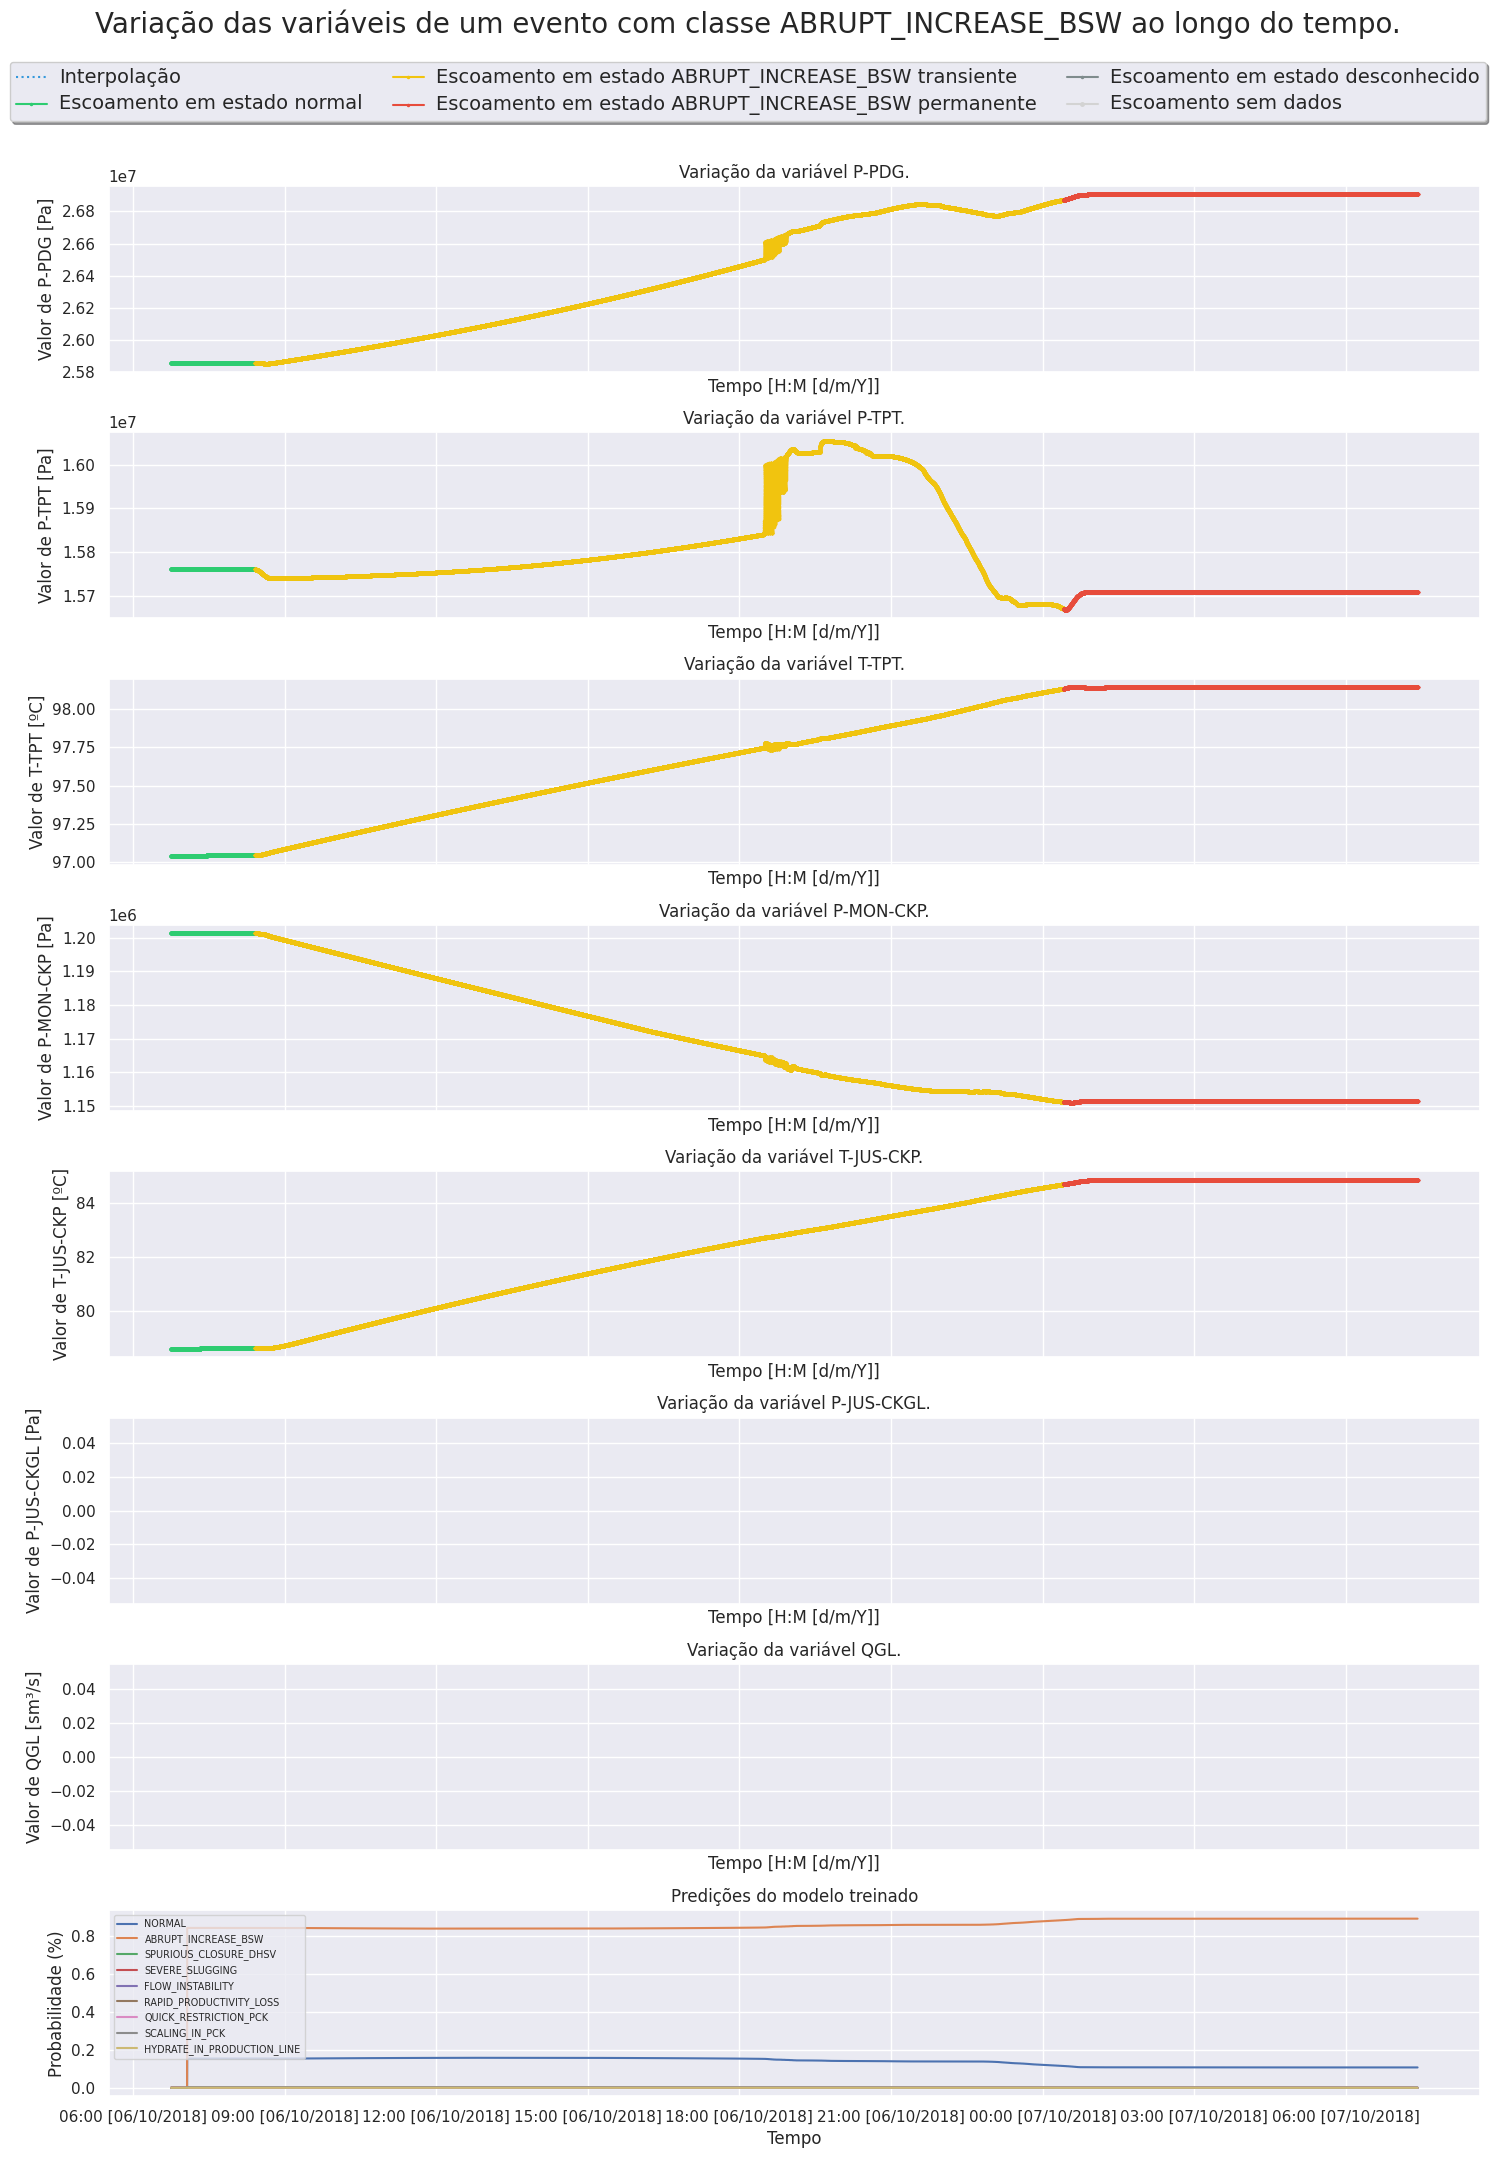

In [113]:
show_event_with_prediction("SIMULATED_00009", 1)
#WELL-00002_20140126161944.npz
#WELL-00001_20140124093303
#SIMULATED_00009

12/12 [==============================] - 0s 7ms/step


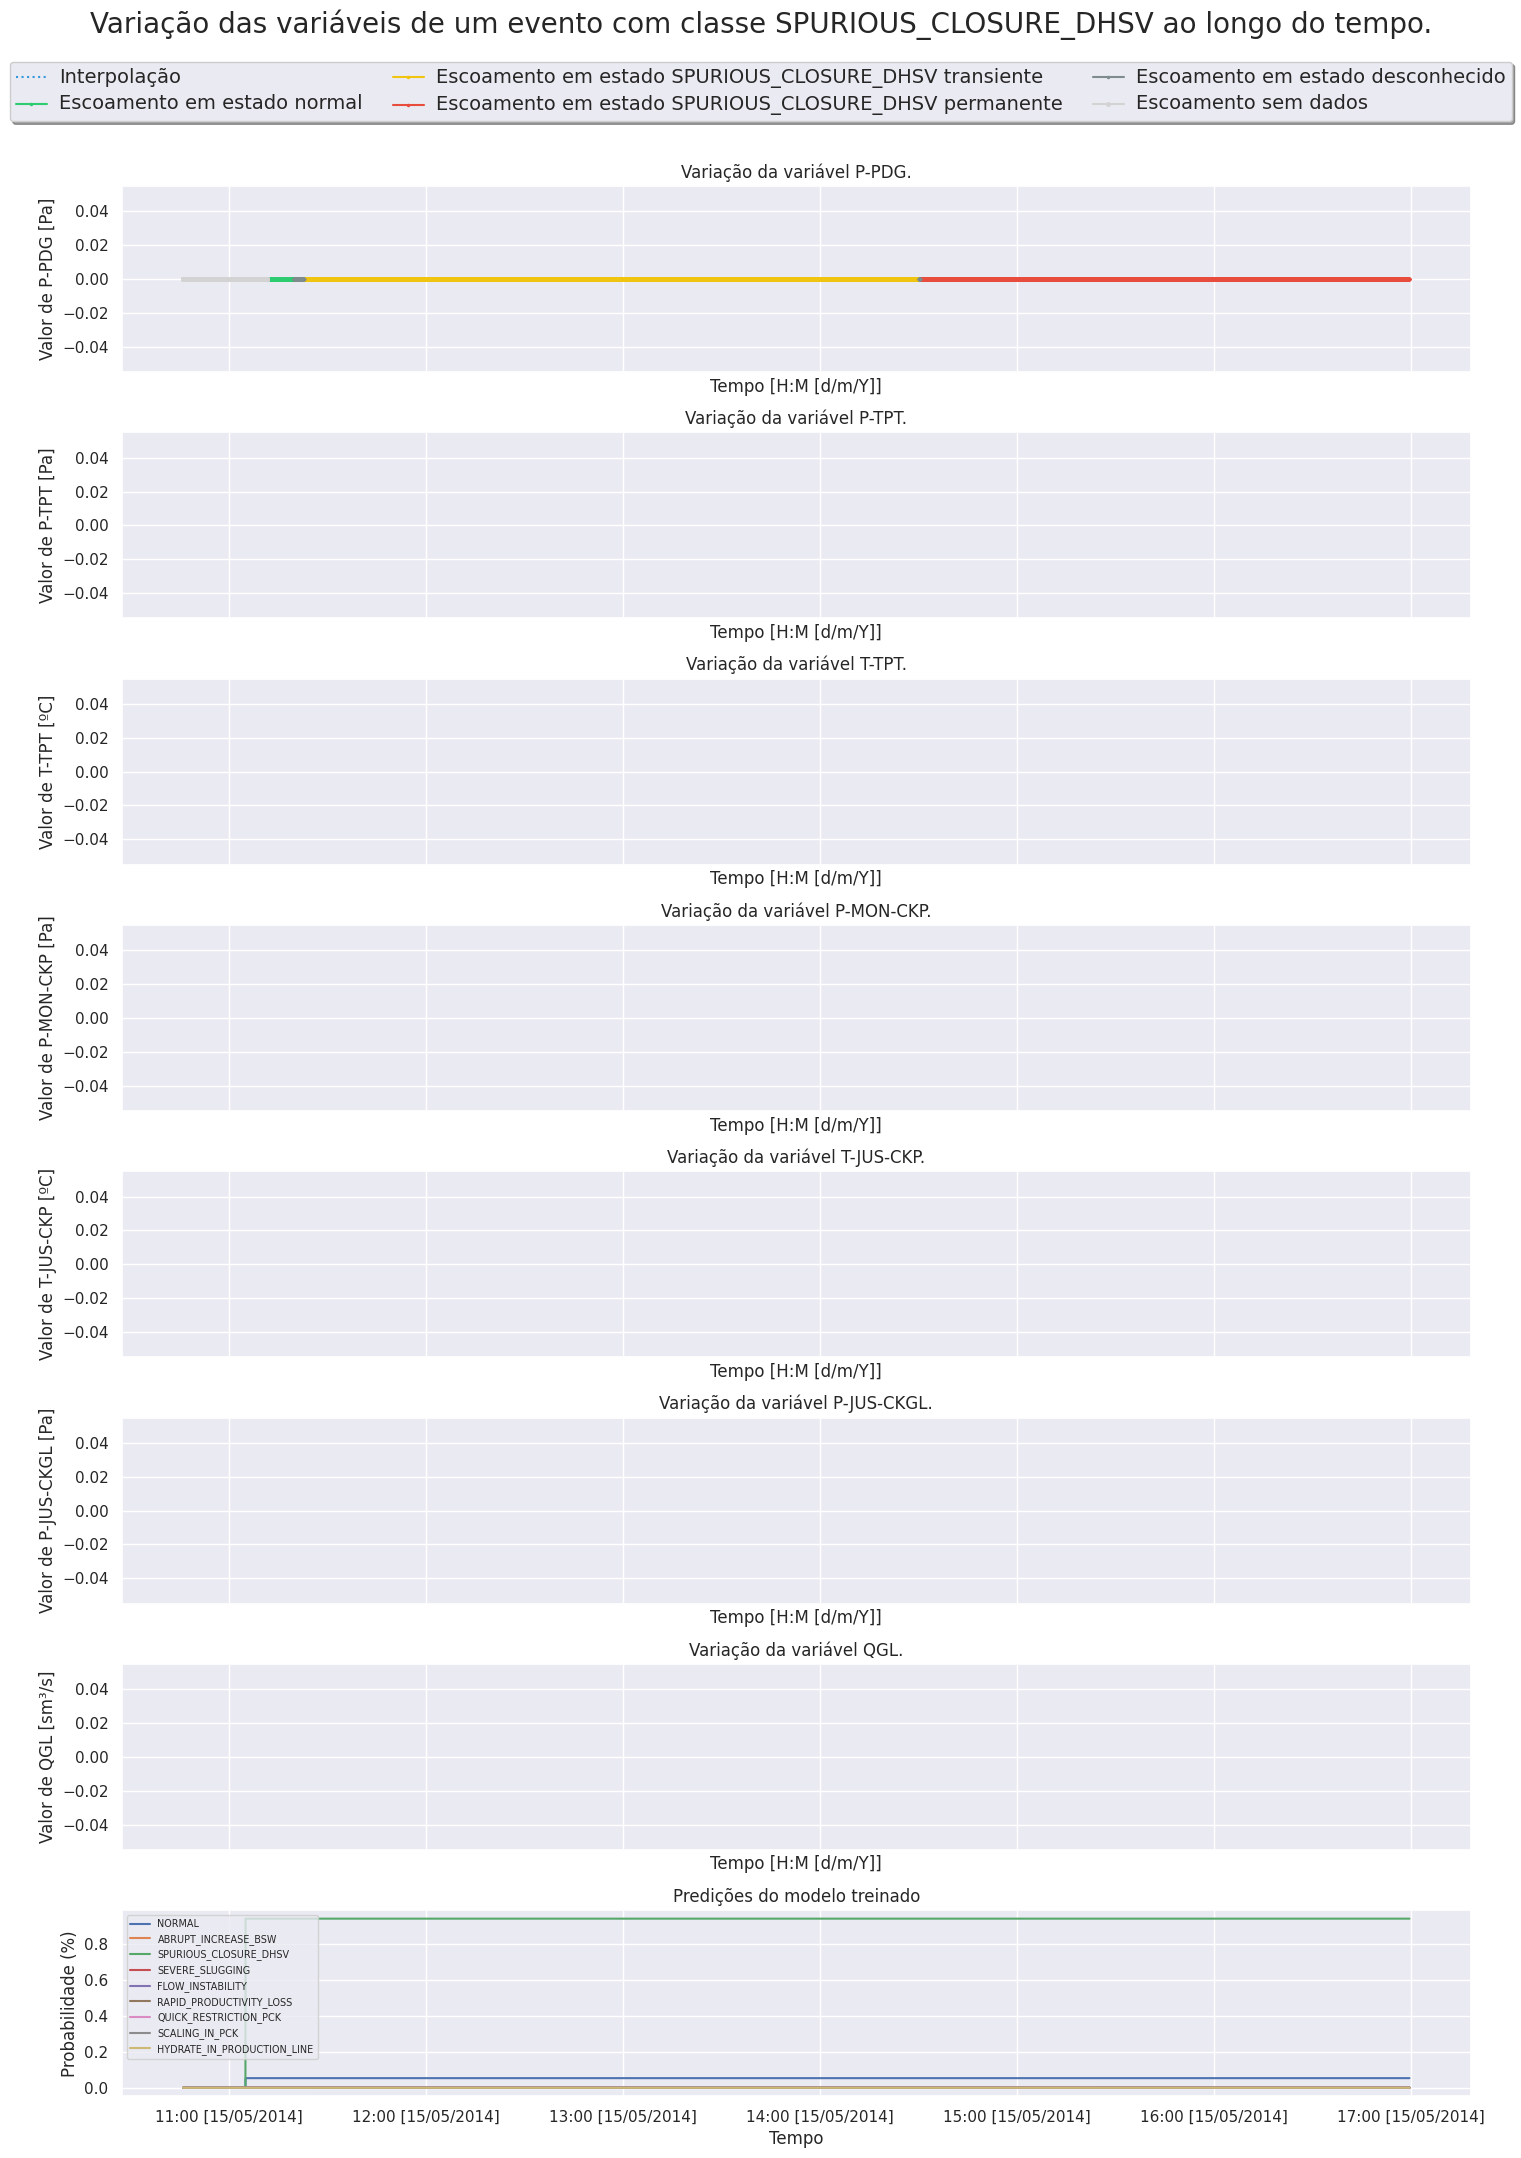

In [61]:
show_event_with_prediction("WELL-00011_20140515104609", 2)

9/9 [==============================] - 0s 7ms/step


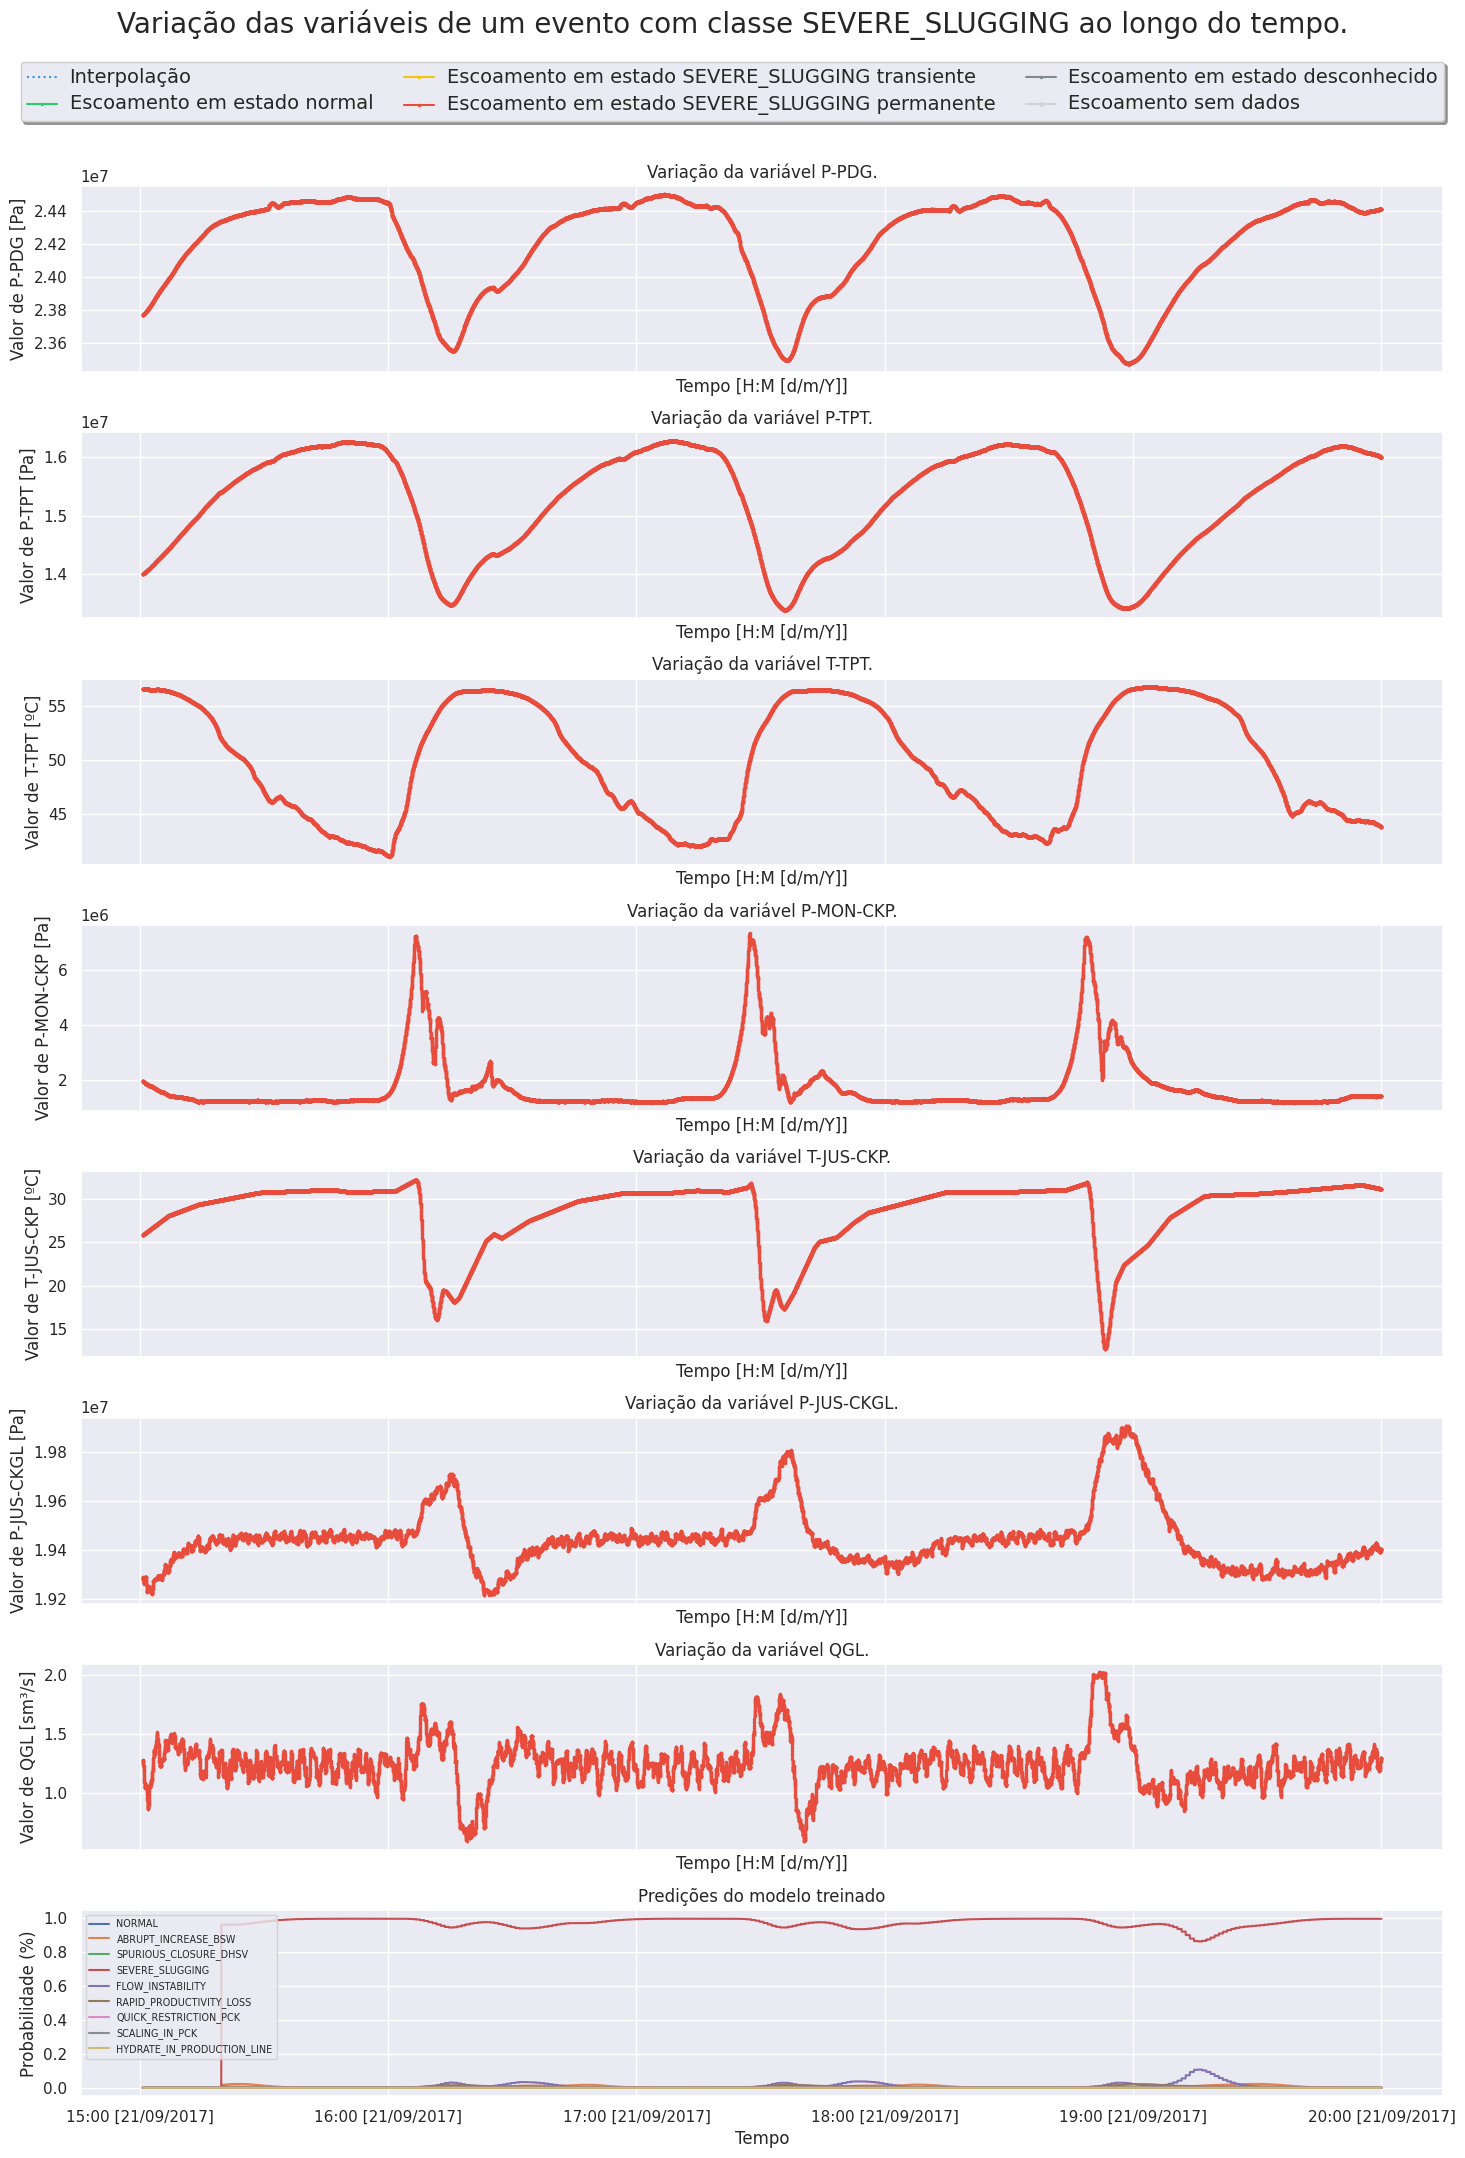

In [62]:
show_event_with_prediction("WELL-00014_20170921150042", 3)


4/4 [==============================] - 0s 7ms/step


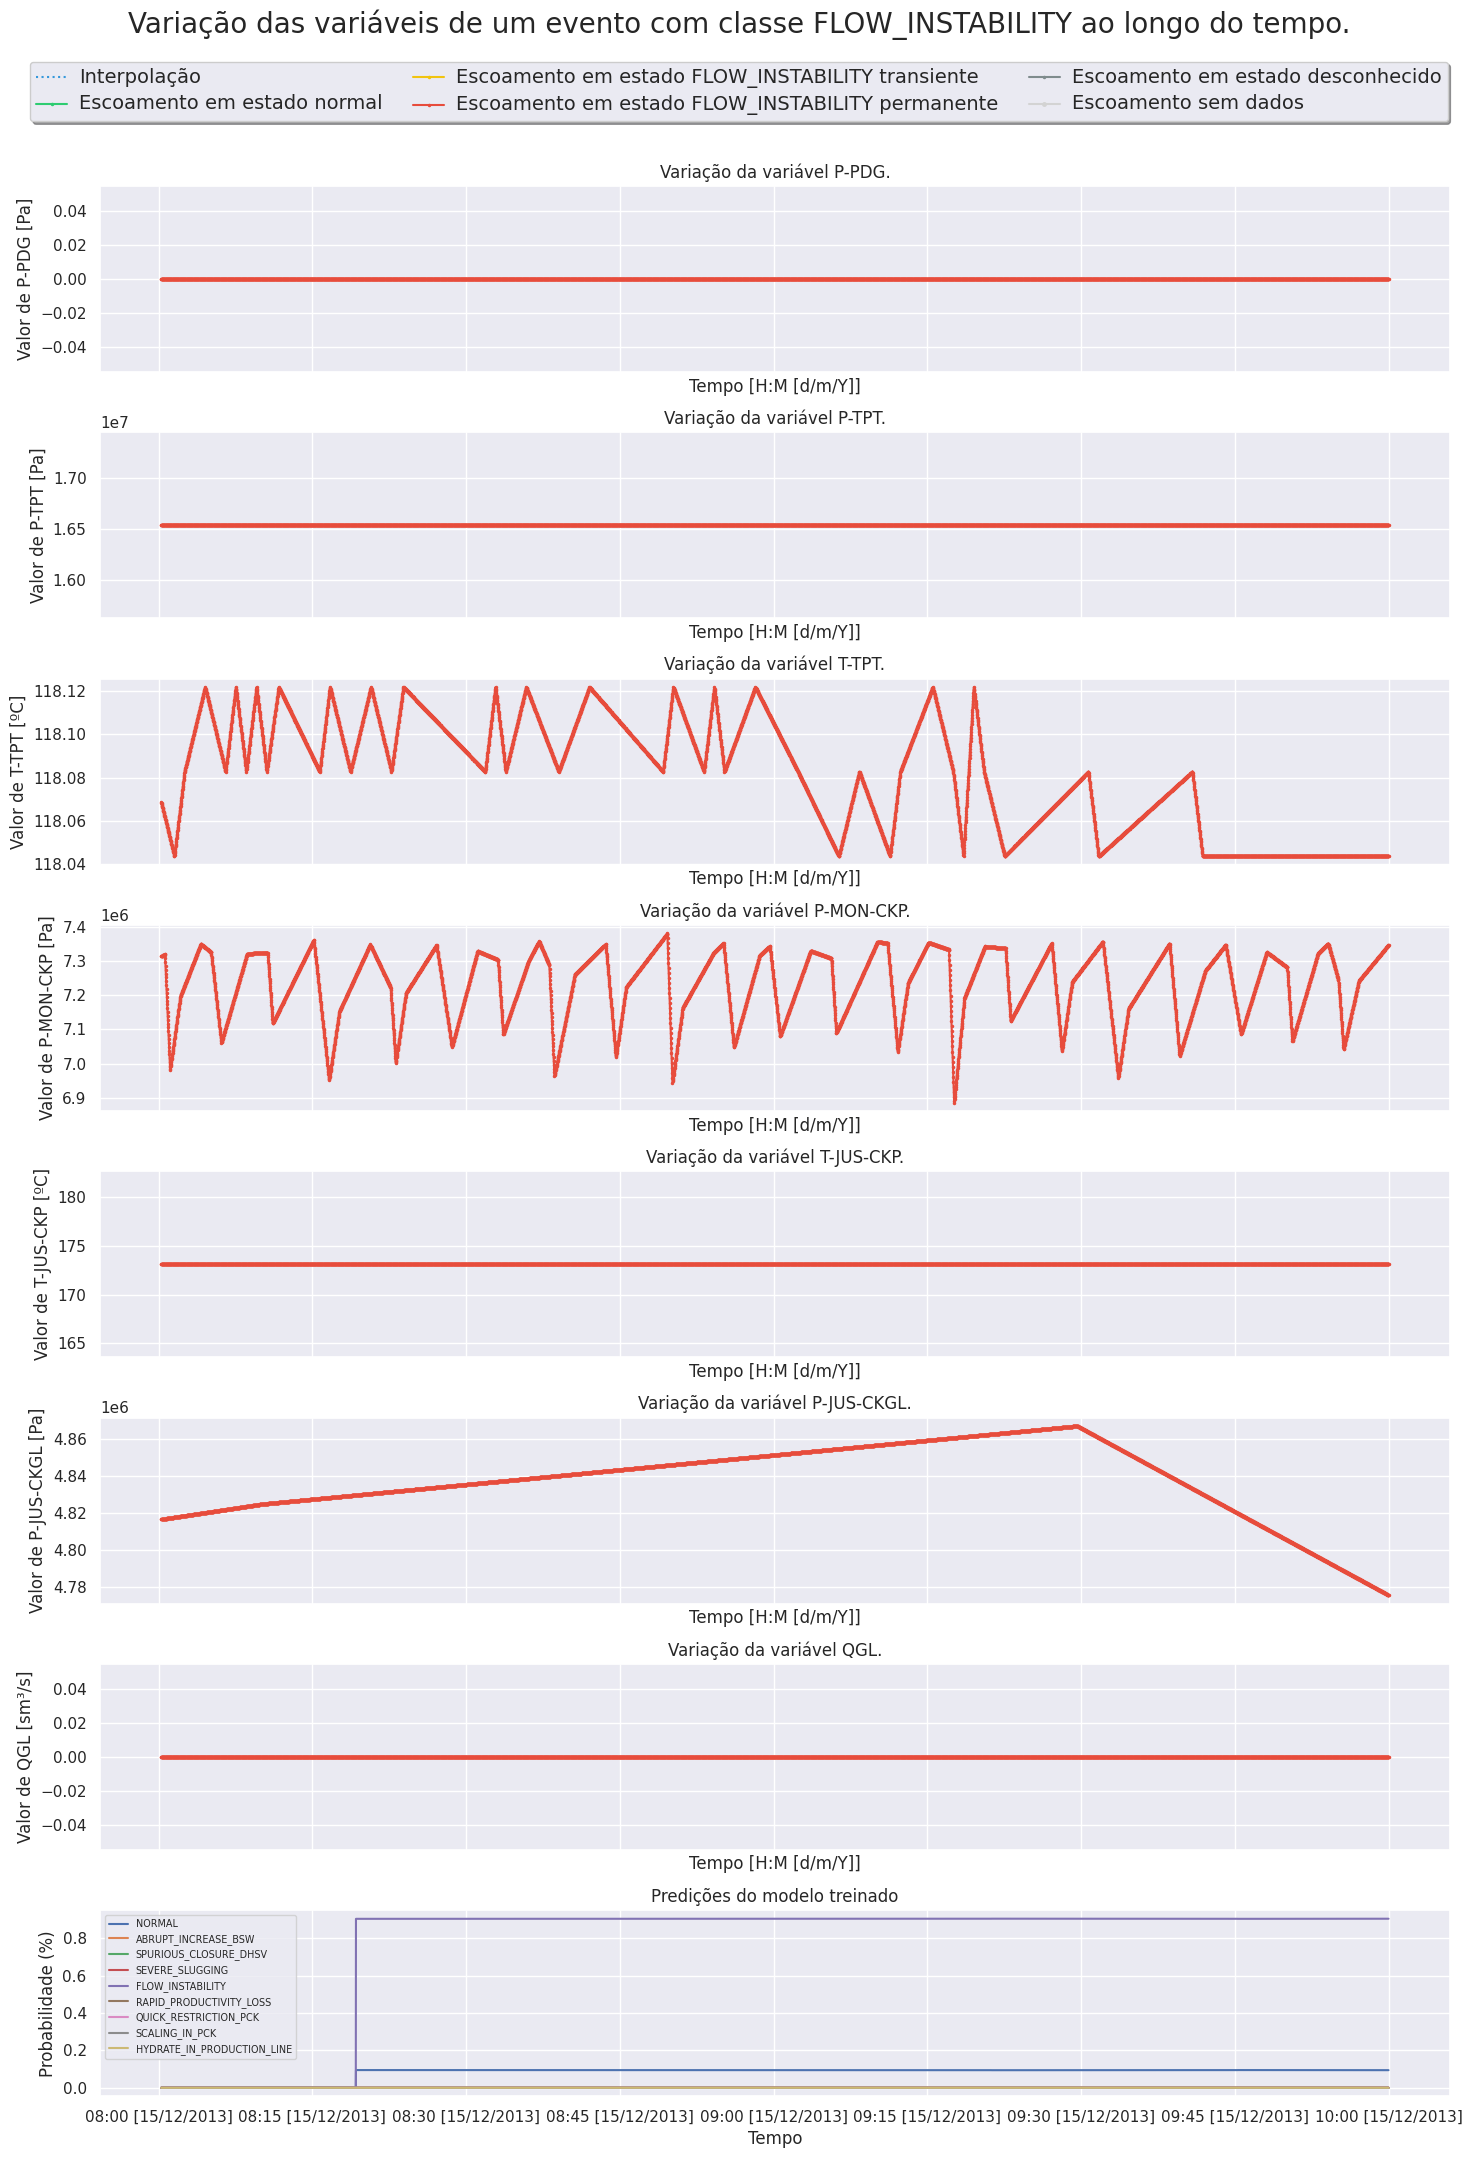

In [63]:
show_event_with_prediction("WELL-00002_20131215080015", 4)
#data/dataset_converted_v10101_split-20_source-all_class-all_well-all_train/4/WELL-00002_20131215080015.parquet

80/80 [==============================] - 1s 7ms/step


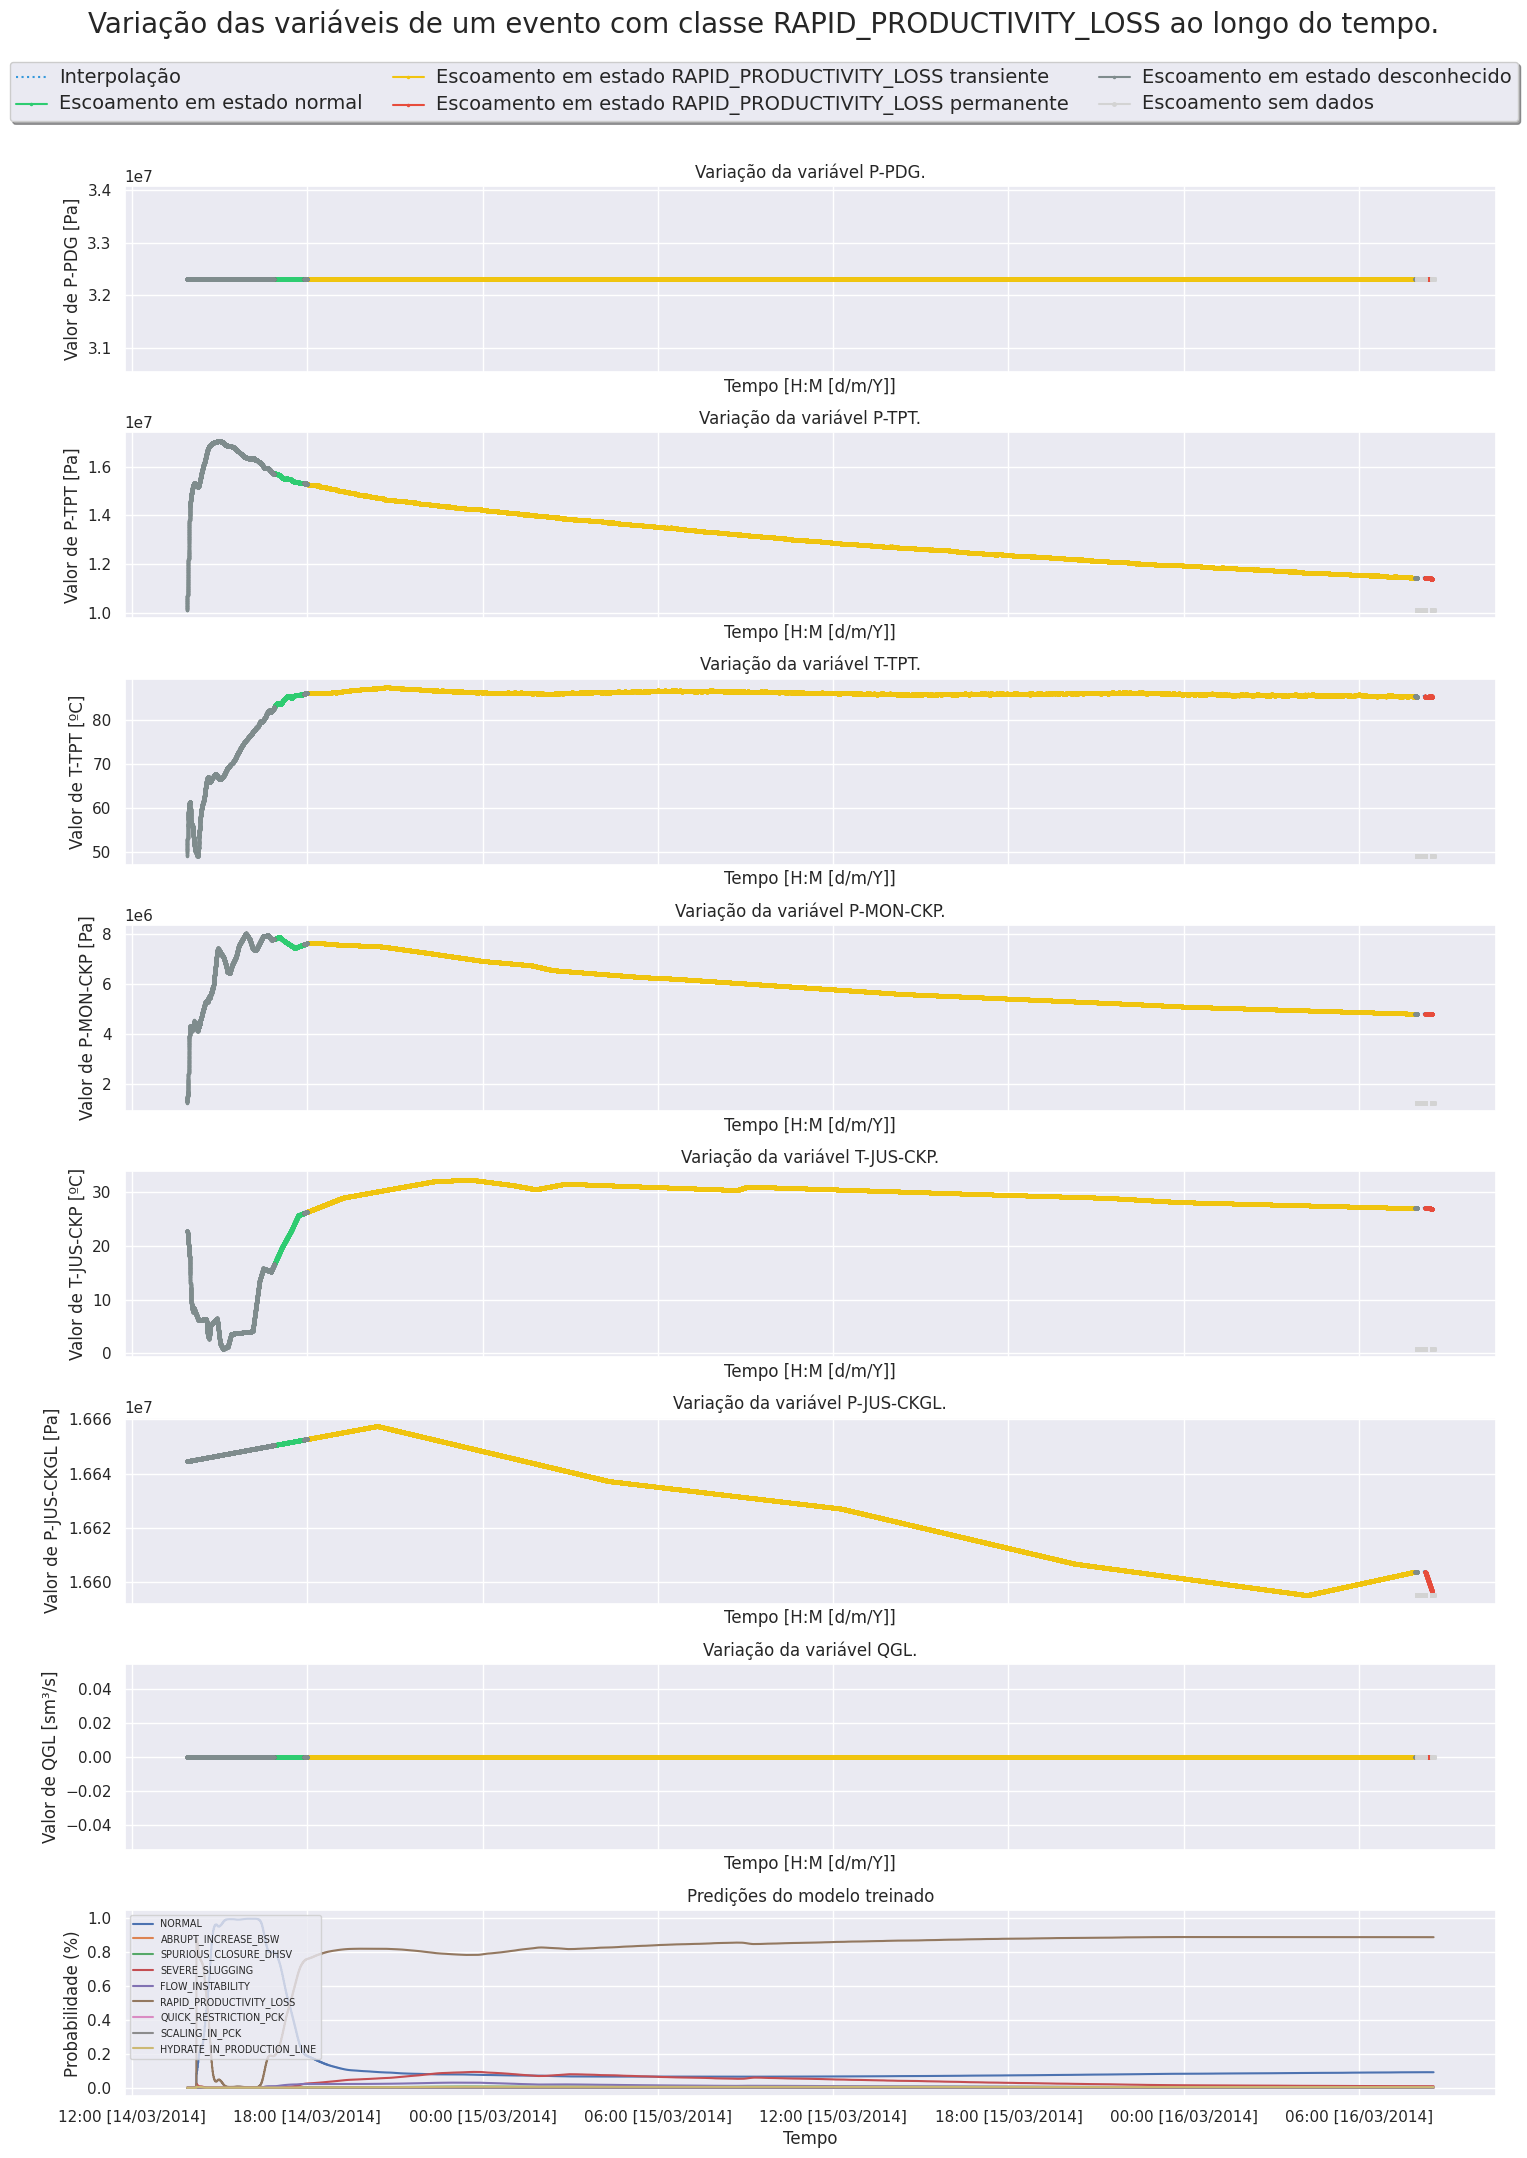

In [112]:
show_event_with_prediction("WELL-00017_20140314135248", 5)
#WELL-00017_20140314135248

6/6 [==============================] - 0s 6ms/step


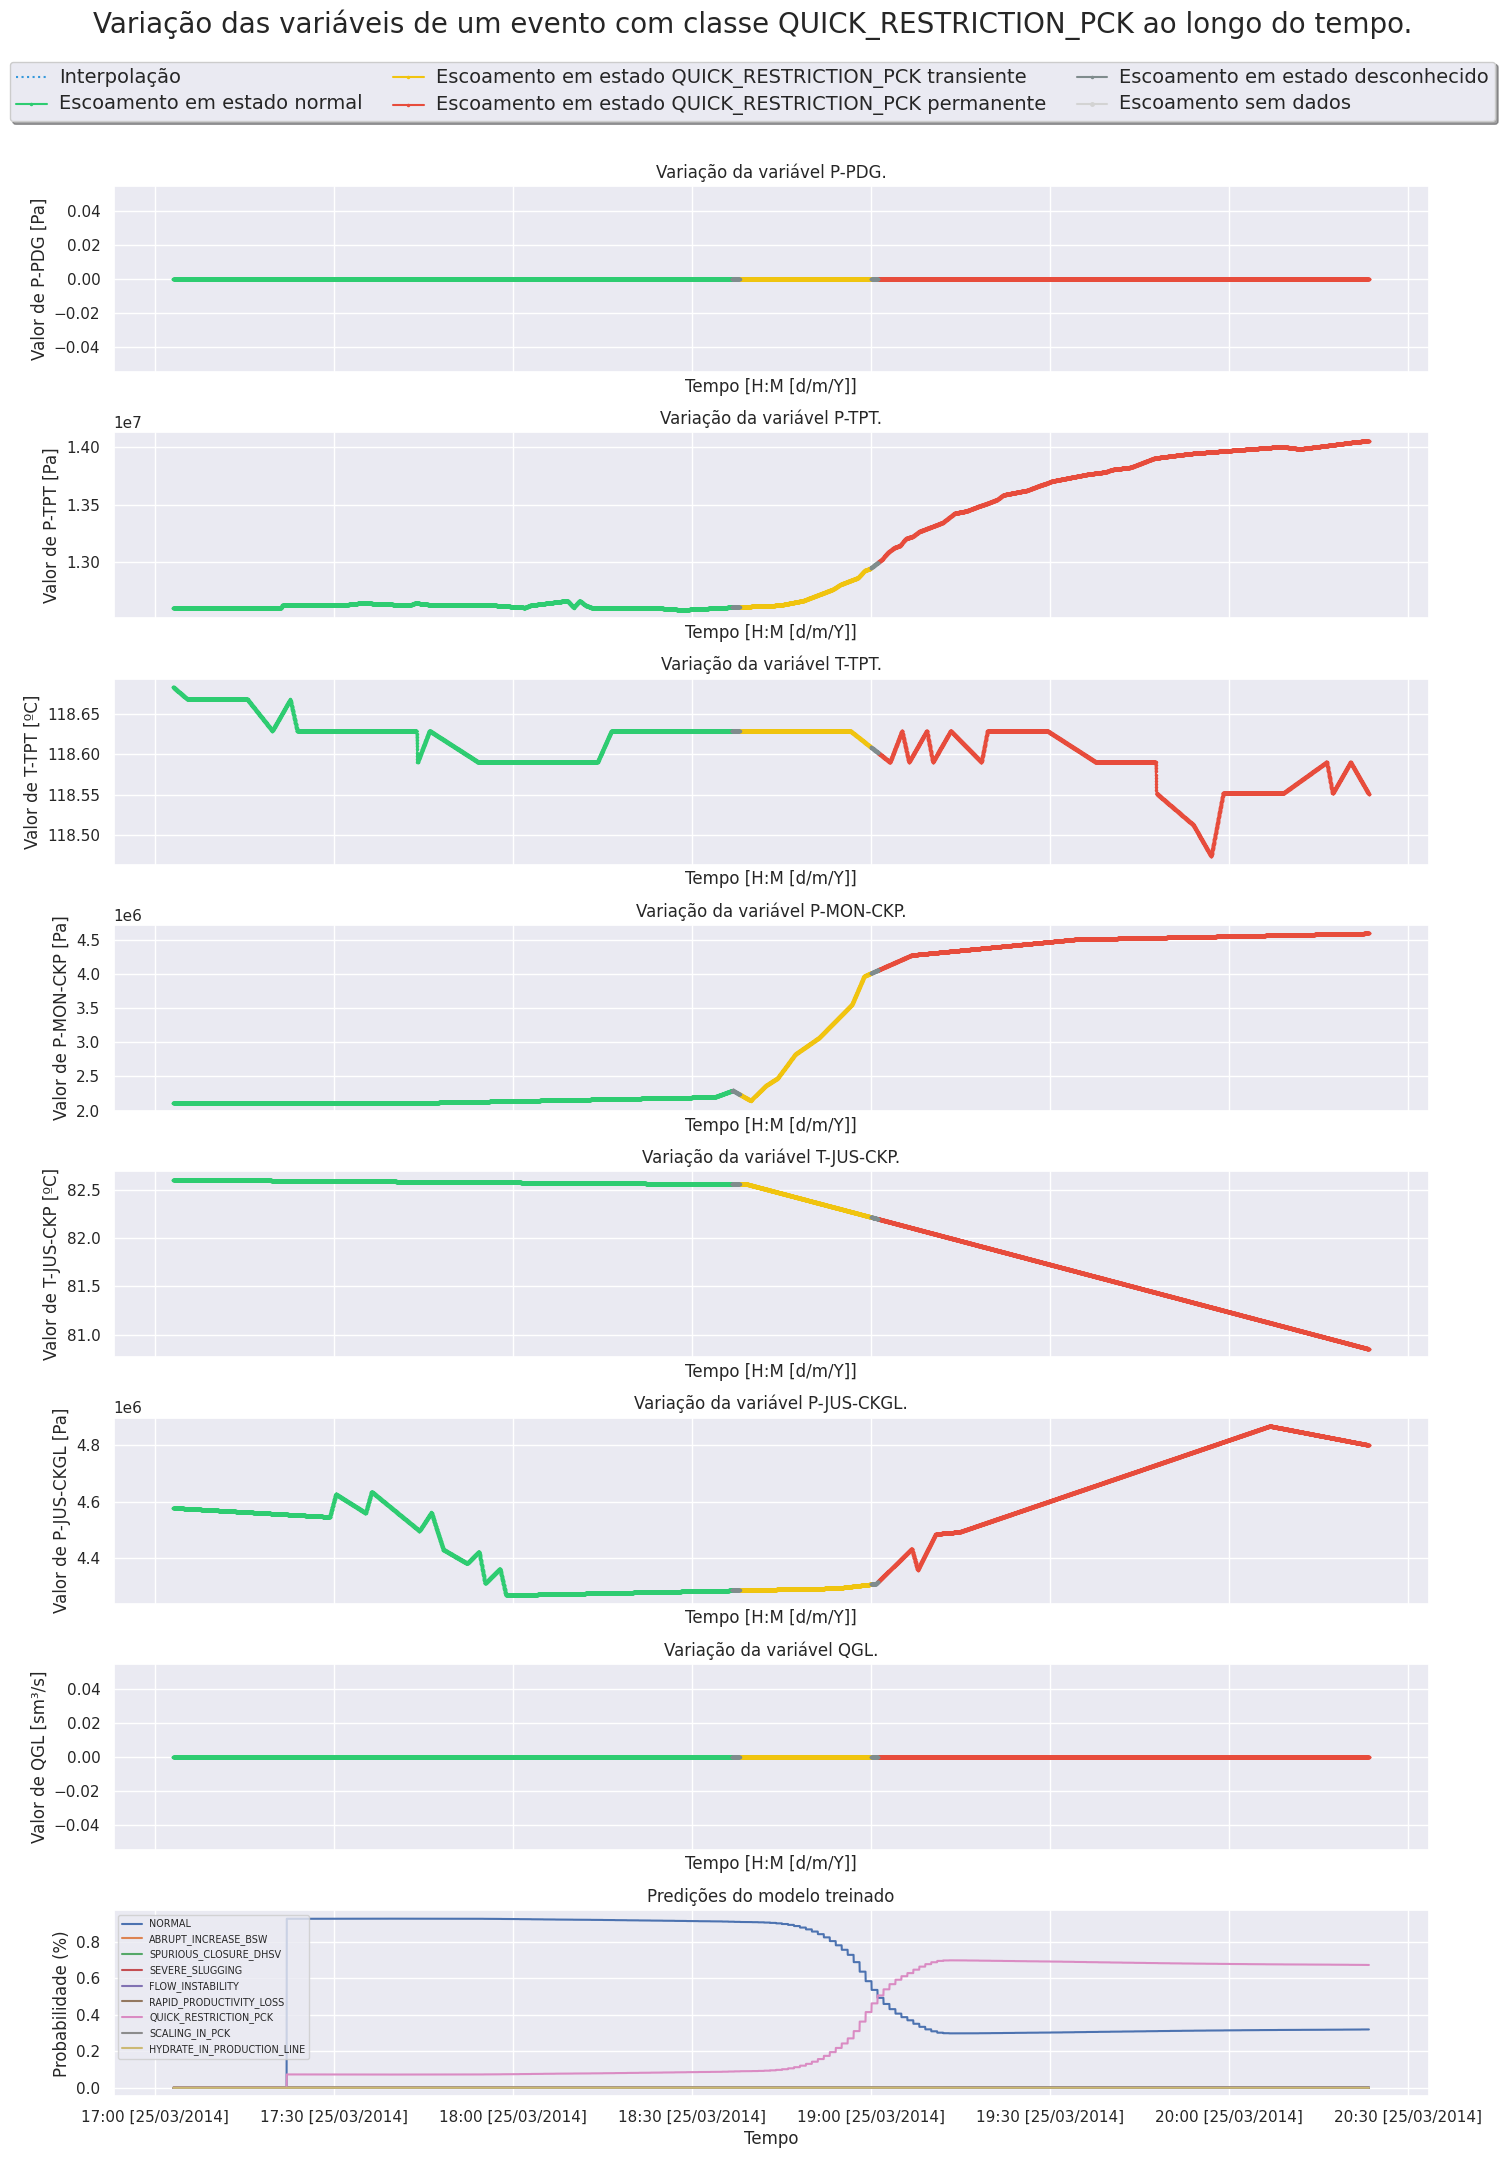

In [114]:
show_event_with_prediction("WELL-00002_20140325170304", 6)
#WELL-00002_20140325170304.npz
#WELL-00004_20171031194452
#data/dataset_converted_v10101_split-20_source-all_class-all_well-all_train/6/WELL-00004_20171031194452.parquet

23/23 [==============================] - 0s 7ms/step


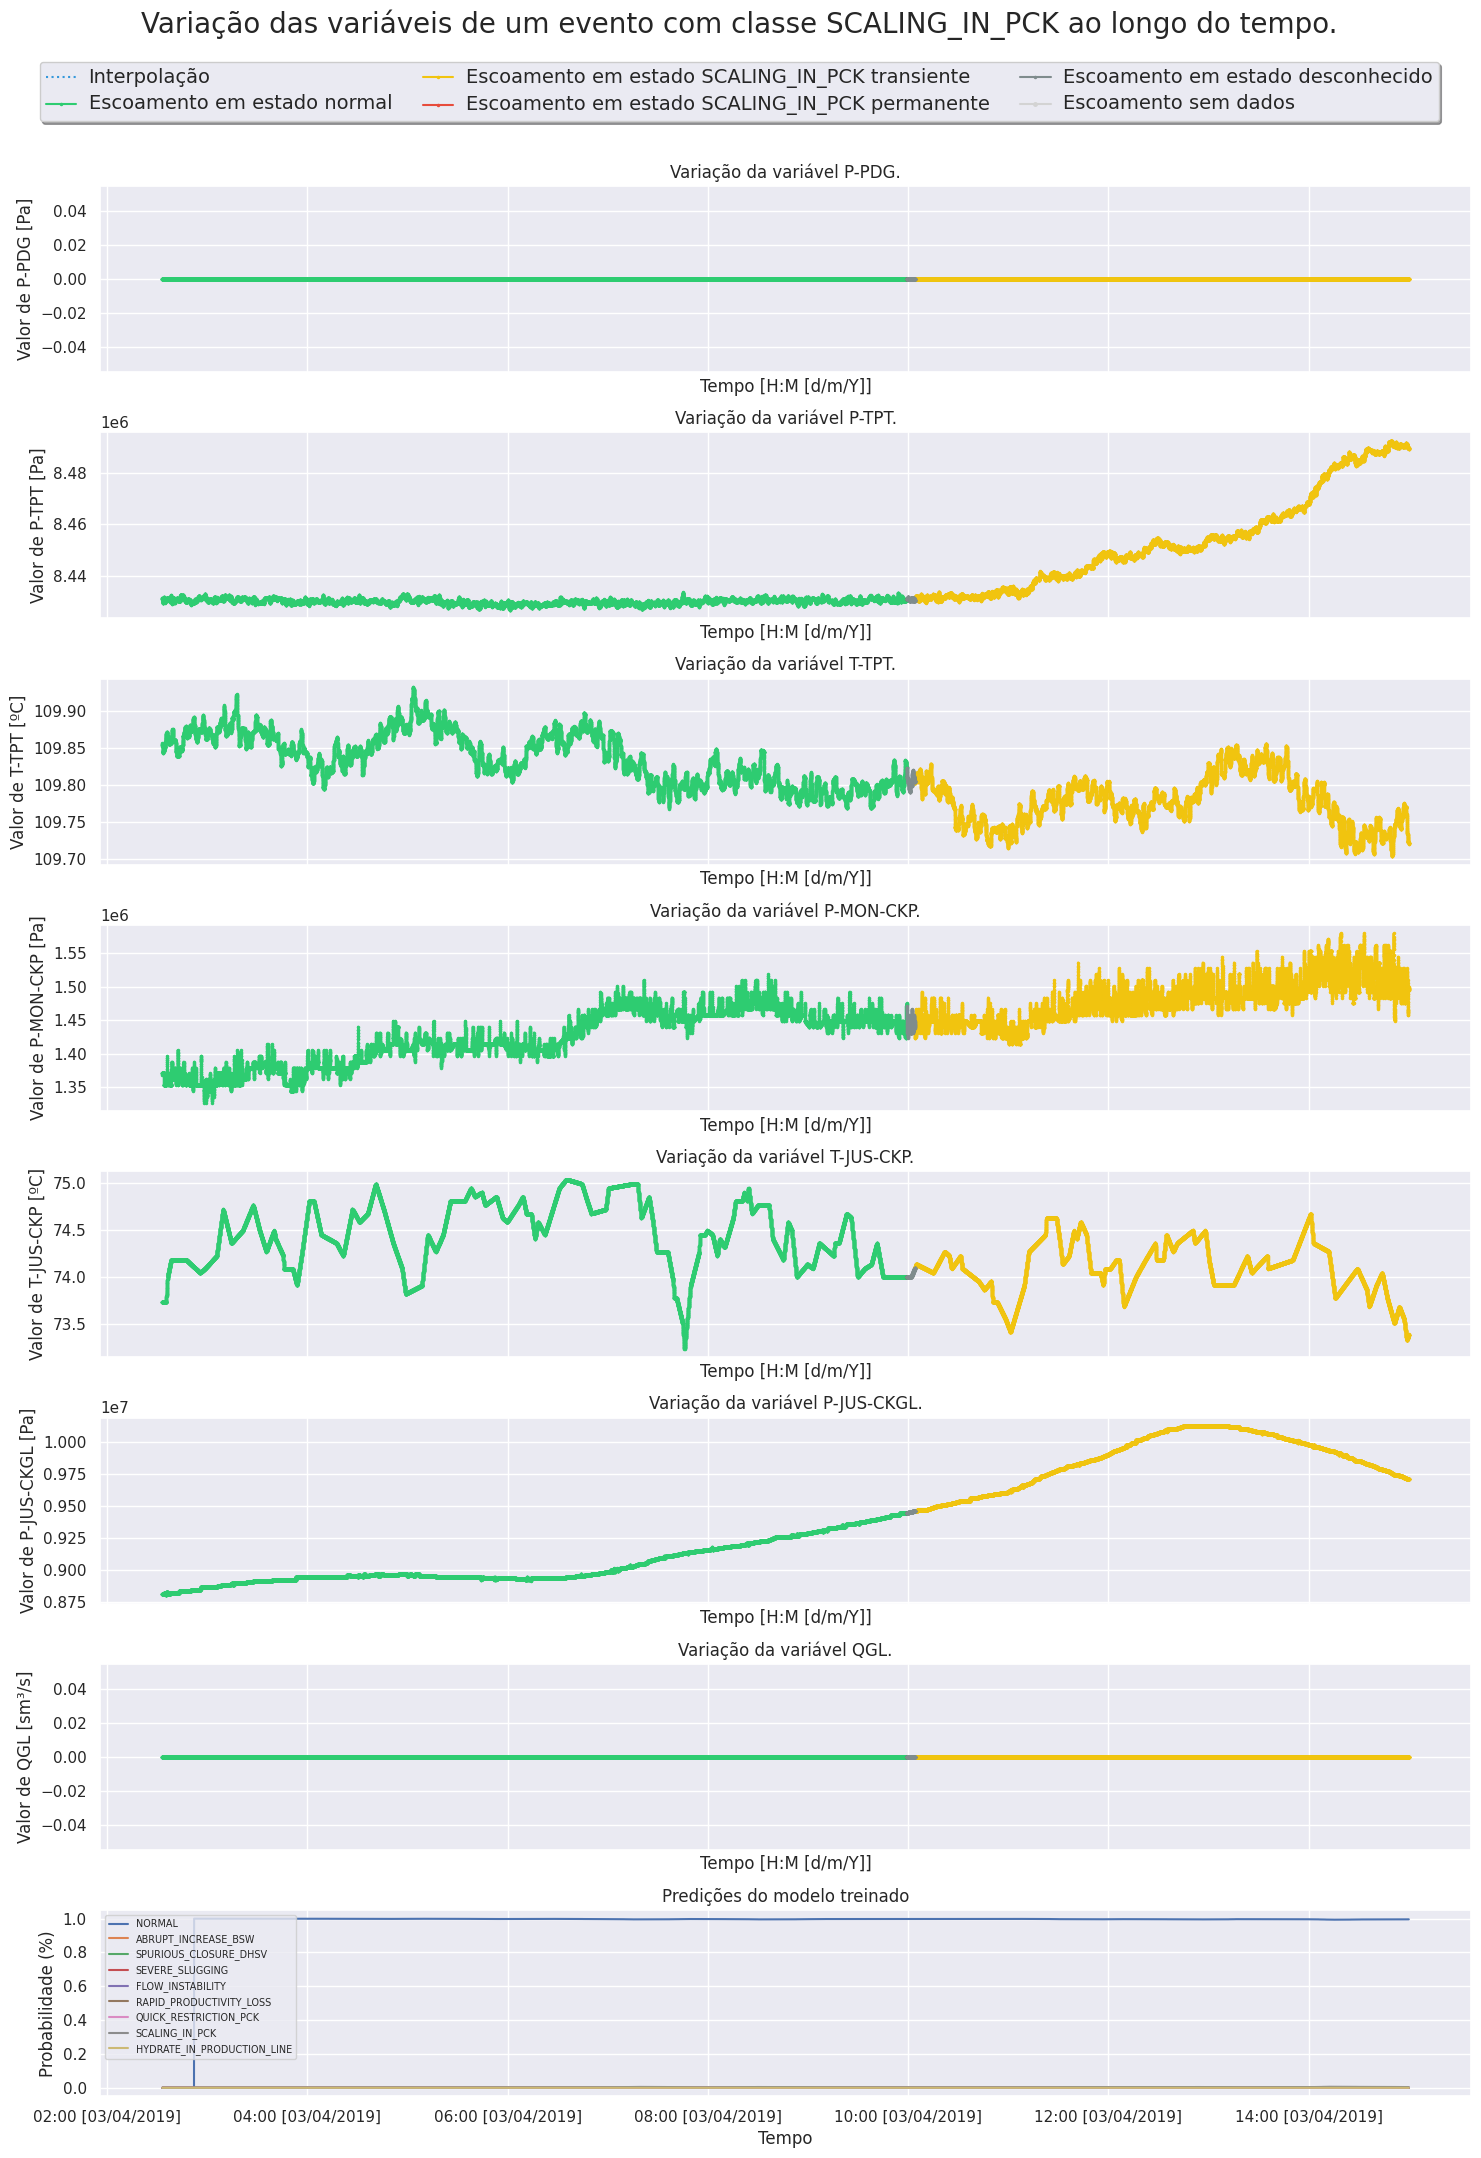

In [68]:
show_event_with_prediction("WELL-00018_20190403023307", 7)
#data/dataset_converted_v10101_split-20_source-all_class-all_well-all_train/7/WELL-00018_20190403023307.parquet

14/14 [==============================] - 0s 7ms/step


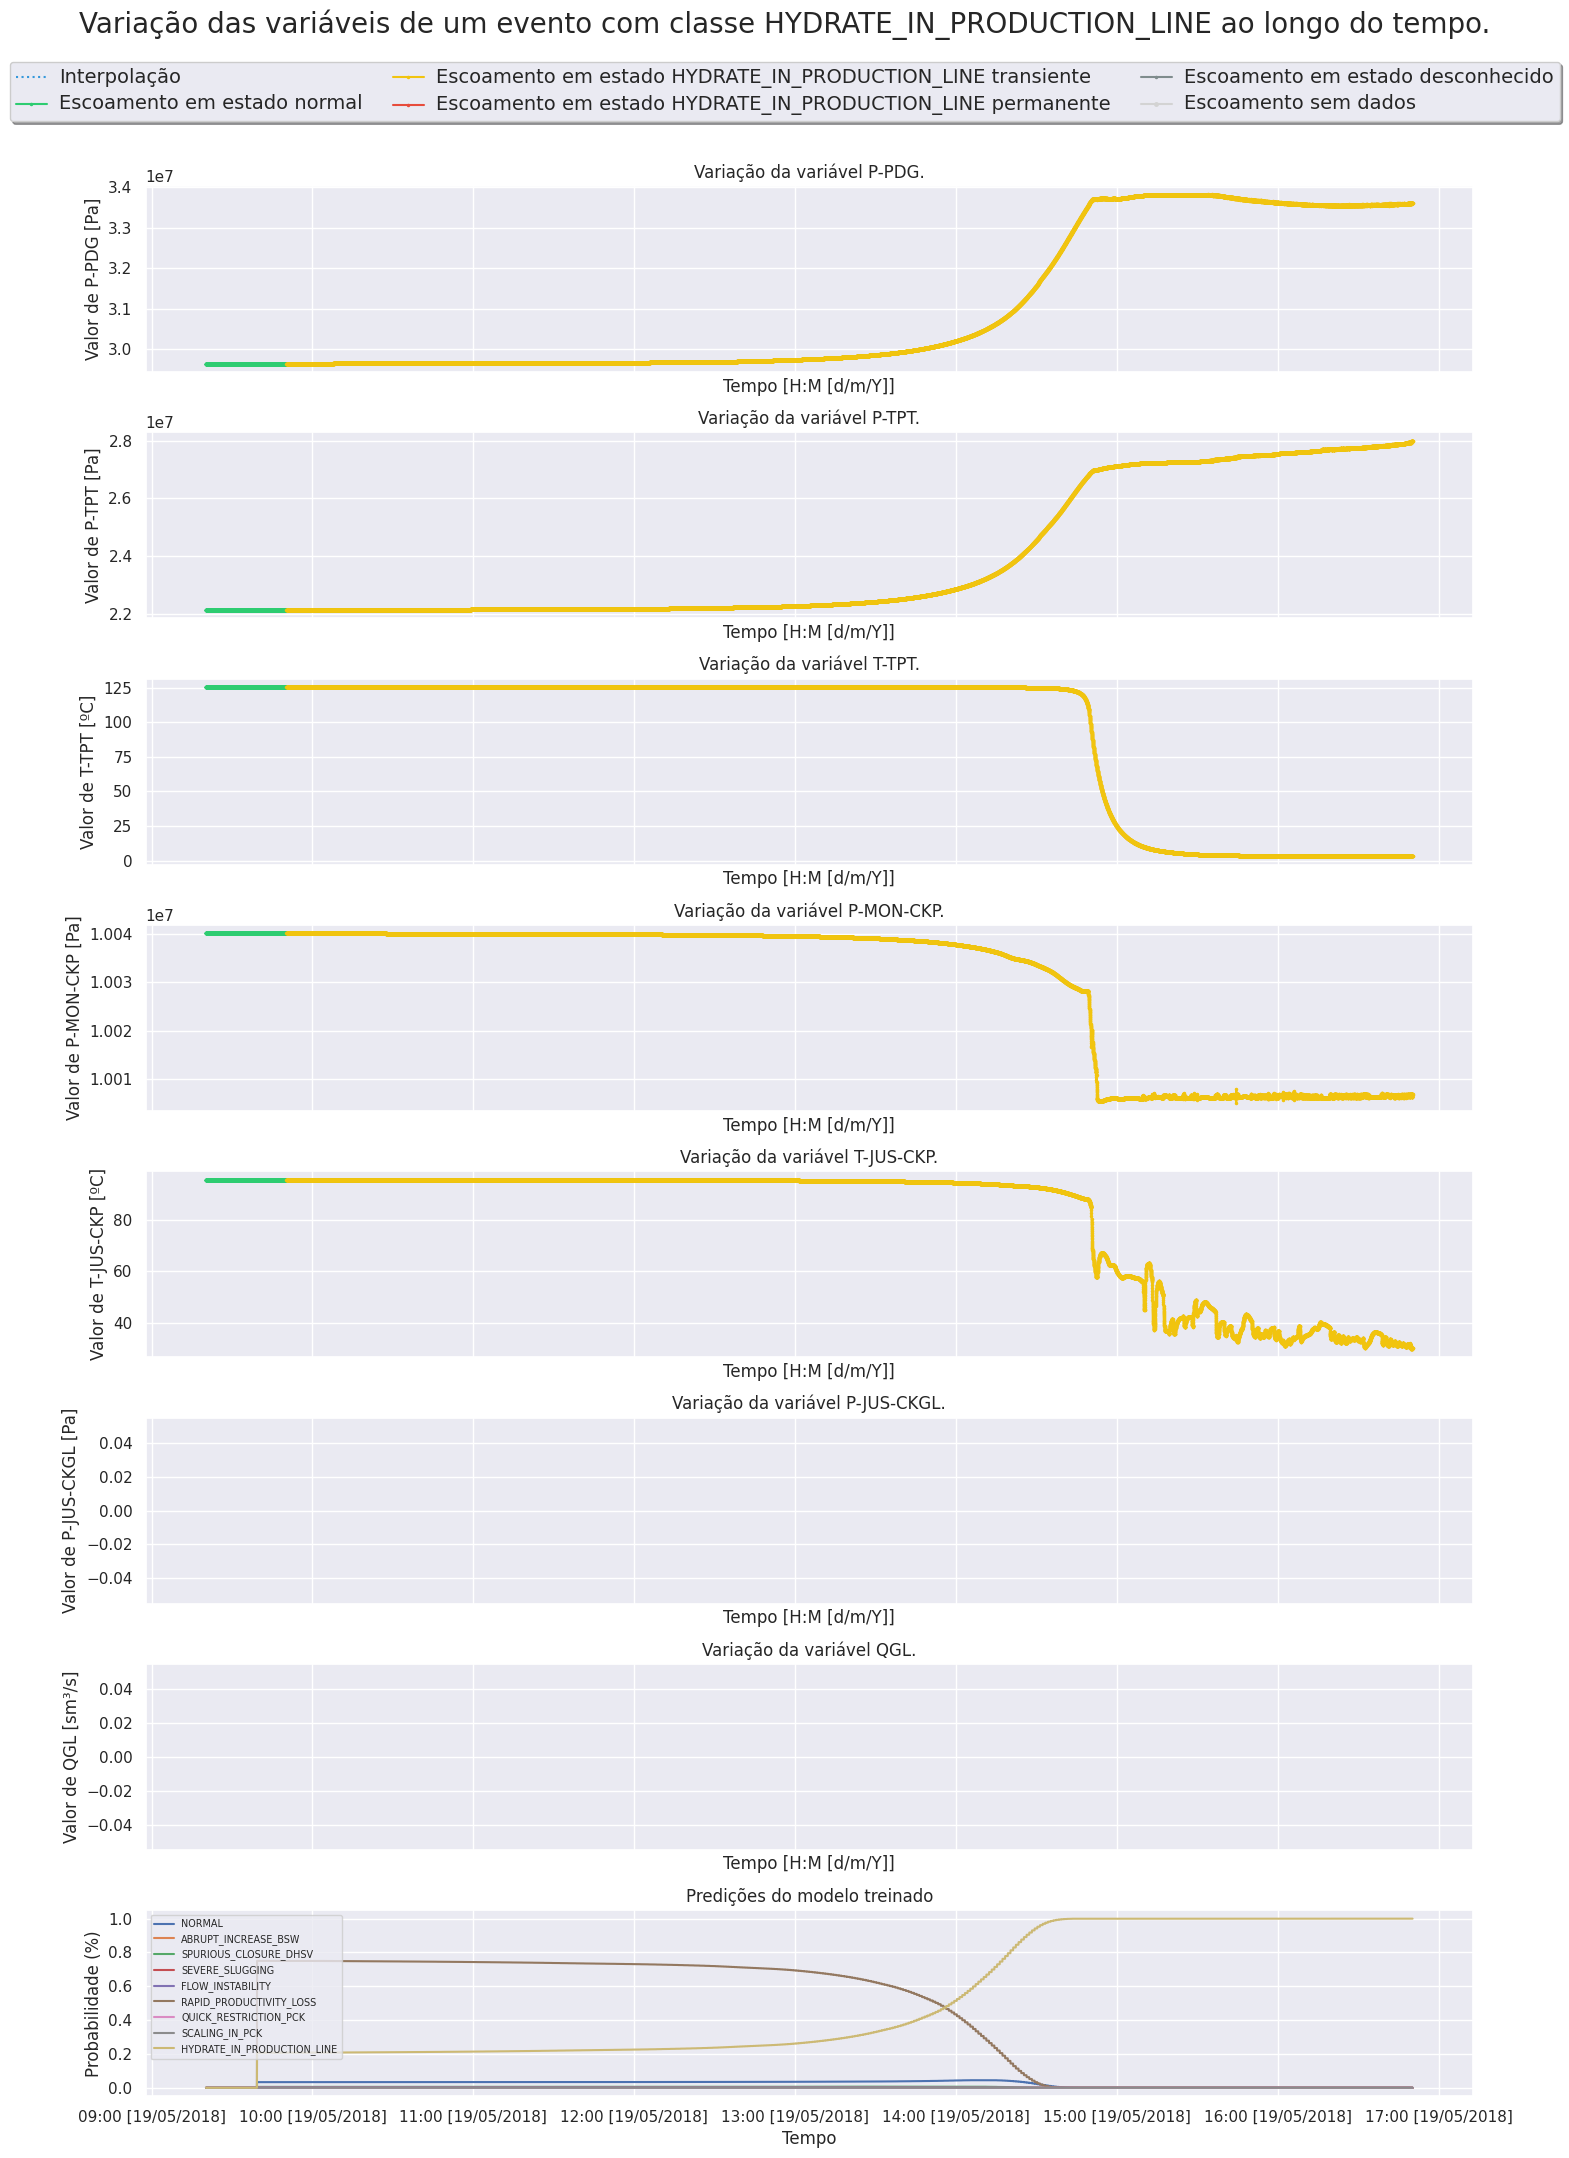

In [69]:
show_event_with_prediction("SIMULATED_00073", 8)
#data/dataset_converted_v10101_split-20_source-all_class-all_well-all_train/8/SIMULATED_00073.parquet

In [ ]:
event1 = rda.get_event("data/dataset_converted_v10101_split-20_source-all_class-all_well-all_train/1/WELL-00002_20140126161944.parquet")
X1, y1 = TransformationManager.retrieve_pair_array(pathlib.Path("data/transform-isdt-dataset_converted_v10101_split-20_source-all_class-all_well-all_train/1/WELL-00002_20140126161944.npz"))

X1.shape, y1.shape, event1.shape

In [ ]:
event1 = rda.get_event("data/dataset_converted_v10101_split-20_source-all_class-all_well-all_train/1/WELL-00002_20140126161944.parquet")
X1, y1 = TransformationManager.retrieve_pair_array(pathlib.Path("data/transform-isdt-dataset_converted_v10101_split-20_source-all_class-all_well-all_train/1/WELL-00002_20140126161944.npz"))

X1.shape, y1.shape, event1.shape